# Joint lightcurve - radial velocity model with multivariate prior

In [1]:
import lightkurve as lk
import astropy.table as astab
import pandas as pd
import numpy as np
import astropy
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
# %pylab inline
# pylab.rcParams['figure.figsize'] = (16, 8)
import warnings
import astropy.table as astab
from astropy.io import fits

warnings.filterwarnings('ignore',
    message="WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size:"
)
print(astropy.__version__)

import pickle as pk
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess
import exoplanet as xo

import arviz as az
from corner import corner

from scipy.signal import savgol_filter
import wquantiles

# %matplotlib widget
dd = "/Users/kjaehnig/CCA_work/GAT/"

def docs_setup():
    """Set some environment variables and ignore some warnings for the docs"""
    import logging
    import warnings


    # Remove when Theano is updated
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Remove when arviz is updated
    warnings.filterwarnings("ignore", category=UserWarning)

    logger = logging.getLogger("theano.gof.compilelock")
    logger.setLevel(logging.ERROR)
    logger = logging.getLogger("theano.tensor.opt")
    logger.setLevel(logging.ERROR)
    logger = logging.getLogger("exoplanet")
    logger.setLevel(logging.DEBUG)

docs_setup()

4.3.1


# LOAD IN ALLVISIT FILE (an absolute unit: ~ 2.75GB)

In [2]:
allvis17 = astab.Table.read("/Users/kjaehnig/CCA_work/GAT/dr17_joker/allVisit-dr17-synspec.fits",hdu=1, format='fits')
allstar17 = astab.Table.read("/Users/kjaehnig/CCA_work/GAT/dr17_joker/allStar-dr17-synspec-gaiaedr3-xm.fits")
allstar17 = allstar17[(allstar17['bp_rp'] < 10) & (allstar17['phot_g_mean_mag'] < 25)]
calibverr = astab.Table.read(dd+'dr17_joker/allVisit-dr17-synspec-min3-calibverr.fits', format='fits', hdu=1)


print(len(allvis17['APOGEE_ID']))
print(allvis17.columns)
hq_jk_allstar_tess_edr3 = astab.Table.read(dd+'dr17_joker/unimodal_joker_sample_joined_w_tess_edr3_REDUX.fits', format='fits')
print(len(hq_jk_allstar_tess_edr3))

2659178
<TableColumns names=('APOGEE_ID','TARGET_ID','VISIT_ID','FILE','FIBERID','CARTID','PLATE','MJD','TELESCOPE','SURVEY','FIELD','PROGRAMNAME','ALT_ID','LOCATION_ID','RA','DEC','GLON','GLAT','RELFLUX','MTPFLUX','J','J_ERR','H','H_ERR','K','K_ERR','SRC_H','WASH_M','WASH_M_ERR','WASH_T2','WASH_T2_ERR','DDO51','DDO51_ERR','IRAC_3_6','IRAC_3_6_ERR','IRAC_4_5','IRAC_4_5_ERR','IRAC_5_8','IRAC_5_8_ERR','IRAC_8_0','IRAC_8_0_ERR','WISE_4_5','WISE_4_5_ERR','TARG_4_5','TARG_4_5_ERR','WASH_DDO51_GIANT_FLAG','WASH_DDO51_STAR_FLAG','PMRA','PMDEC','PM_SRC','AK_TARG','AK_TARG_METHOD','AK_WISE','SFD_EBV','APOGEE_TARGET1','APOGEE_TARGET2','APOGEE_TARGET3','APOGEE_TARGET4','TARGFLAGS','SNR','STARFLAG','STARFLAGS','DATEOBS','JD','VLSR','VGSR','CHISQ','SYNTHFILE','MIN_H','MAX_H','MIN_JK','MAX_JK','VREL','VRELERR','VHELIO','BC','RV_TEFF','RV_LOGG','RV_FEH','RV_CARB','RV_ALPHA','XCORR_VREL','XCORR_VRELERR','XCORR_VHELIO','CCFWHM','AUTOFWHM','RV_CHI2','N_COMPONENTS','RV_COMPONENTS','RV_FLAG')>
1741


In [3]:
def get_multiple_ranges(lk_coll):
    from itertools import groupby
    from operator import itemgetter

    ranges =[]
    inds = []
    data = [ii.sector for ii in lk_coll]
    for k,g in groupby(enumerate(data),lambda x:x[0]-x[1]):
        group = (map(itemgetter(1),g))
        group = list(map(int,group))
        inds.append([ii in group for ii in data])
        ranges.append((group[0],group[-1]))
        
    return data,ranges, inds



In [4]:
def get_texp_from_lightcurve(res):
    with fits.open(res['all_lks'].filename) as hdu:
        hdr = hdu[1].header

    texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
    texp /= 60.0 * 60.0 * 24.0
    print(texp, texp*60*60*24)

    return texp


In [ ]:
def get_system_data_for_pymc3_model(TICID):
    
    file = open(f"/Users/kjaehnig/CCA_work/GAT/joker_TESS_lightcurve_files/{TICID.replace(' ','_').replace('-','_')}_highres_bls_params.pickle",'rb')
    blsres = pk.load(file)
    file.close()

    file = open(f"/Users/kjaehnig/CCA_work/GAT/joker_TESS_lightcurve_files/{TICID.replace(' ','_').replace('-','_')}_lightcurve_data.pickle","rb")
    res = pk.load(file)
    file.close()
    
        #     print(calibverr.info)
    # Grab cross-match IDs
    sysapodat = allvis17[allvis17['APOGEE_ID'] == res['joker_param']['APOGEE_ID']]

    ## joining calib RV_ERRs with the RVs
    sysapodat = astab.join(sysapodat, calibverr['VISIT_ID','CALIB_VERR'], keys=('VISIT_ID','VISIT_ID'))
    
    return (res, blsres, sysapodat)


def highres_secondary_transit_bls(res, blsres):
    
    jk_row = res['joker_param']

    
    dur_grid = np.exp(np.linspace(np.log(0.001),np.log(0.1),1000))
    
#     npts = 5000
#     pmin = period_grid.min()
#     pmax = period_grid.max()
#     mindur = dur_grid.min()

    all_lk = res['lk_coll'].stitch(corrector_func=lambda x: x.remove_nans().normalize().flatten())
    
    transit_mask = all_lk.create_transit_mask(
        period=blsres['period_at_max_power'].value,
        duration=5*blsres['duration_at_max_power'].value,
        transit_time=blsres['t0_at_max_power'].value
    )

    no_transit_lks = all_lk[~transit_mask]
        
#     print(f"Running BLS.")

#     maxtime = all_lk.time.max().value
#     mintime = all_lk.time.min().value

#     freq_f = int( ((pmin**-1 - pmax**-1) * (maxtime - mintime)**2) / (npts * mindur) ) 

    x = no_transit_lks.time
    y = no_transit_lks.flux
    yerr = no_transit_lks.flux_err

    cusBLS = astropy.timeseries.BoxLeastSquares(x, y, yerr)

    max_period = 100. * blsres['period_at_max_power'].value
    min_period = .011      #0.5 * jk_row['MAP_P']
    nf =   5 * 10**5    #5 * 10**5
    baseline = max(all_lk.time.value) - min(all_lk.time.value)
    
    min_f = 1. / max_period
    max_f = 1. / min_period
    
    freq_f = ( (max_f - min_f) * baseline**2. ) / ( (nf - 1) * min(dur_grid) )
    
    period_grid = np.array([blsres['period_at_max_power'].value])
                            #cusBLS.autoperiod(dur_grid, 
#                                     maximum_period = max_period,
#                                     minimum_period = min_period,
#                                     frequency_factor=freq_f)
    
#     print(nf, len(period_grid))
#     assert nf==len(period_grid)
    res = cusBLS.power(period_grid, dur_grid)

    maxpow = np.argmax(res['power'])
    cusBLSperiod = res['period'][maxpow]
    cusBLSt0 = res['transit_time'][maxpow]
    cusBLSdur = res['duration'][maxpow]
    cusBLSdepth = res['depth'][maxpow]

    res['period_at_max_power'] = cusBLSperiod
    res['t0_at_max_power'] = cusBLSt0
    res['depth_at_max_power'] = cusBLSdepth
    res['duration_at_max_power'] = cusBLSdur
    res['max_power'] = maxpow
    
    res['no_transit_lk'] = no_transit_lks
        
#     print("Finished.")

    

    
    return res


def estimate_ecosw(bls2res, blsres):
    
    bls1_t0 = blsres['t0_at_max_power']
    bls2_t0 = bls2res['t0_at_max_power']
    
    delT = (bls2_t0.value - bls1_t0.value) % blsres['period_at_max_power'].value
    
    ecosw_testval = ( (np.pi/4.) * ( (2.*delT / blsres['period_at_max_power'].value) - 1) )
    
    return ecosw_testval

# ecosw_tv = estimate_ecosw(bls2res, blsres)
# print(ecosw_tv)

def get_M1_R1_from_binary_model(TIC_TARGET, nsig=3, fig_dest=None):
    """
    FOR LATER CONSIDERATION:
    IMPLEMENT A RECURSIVE MAD-SIGMA CLIPPING THAT CONTINUES CLIPPING AT 3-MAD-SIGMA UNTIL THERE ARE 
    NO MORE CLIPPED DATA POINTS. THIS IS TO ALLOW THE ISOCHRONES POSTERIORS TO HAVE MULTIMODAL DISTRIBUTIONS
    THAT WONT AFFECT THE CONSTRUCTION OF THE MULTIVARIATE PRIOR.
    """
    from isochrones import BinaryStarModel

    ID = TIC_TARGET.split(' ')[1]
    mod = BinaryStarModel.load_hdf(f"/Users/kjaehnig/CCA_work/GAT/pymultinest_fits/tic_{ID}_binary_model_obj.hdf")
#     fig = corner(az.from_dict(mod.derived_samples[['mass_0','mass_1','radius_0','radius_1','Mbol_0','Mbol_1']].to_dict('list')))
    m0,m1,r0,r1,mbol0,mbol1 = mod.derived_samples[['mass_0','mass_1','radius_0', 'radius_1','Mbol_0','Mbol_1']].values.T
    
    num, denom = np.argmin([np.median(m0), np.median(m1)]), np.argmax([np.median(m0), np.median(m1)])
#     mbol_0, mbol_1 = mod.derived_samples.Mbol_0.values,mod.derived_samples.Mbol_1.values
#     num, denom = np.argmin([np.median(m0), np.median(m1)]), np.argmax([np.median(m0), np.median(m1)])
    ms, mp = [m0,m1][num], [m0,m1][denom]

#     num, denom = np.argmin([np.median(r0), np.median(r1)]), np.argmax([np.median(r0), np.median(r1)])
    rs, rp = [r0,r1][num], [r0,r1][denom]
    
#     num, denom = np.argmin([np.median(mbol0), np.median(mbol1)]), np.argmax([np.median(mbol0), np.median(mbol1)])
    mbols,mbolp = [mbol0,mbol1][num], [mbol0,mbol1][denom]
    
    mp_madSD = np.median(abs(mp - np.median(mp))) * 1.4826
    rp_madSD = np.median(abs(rp - np.median(rp))) * 1.4826
    mbp_madSD = np.median(abs(mbolp - np.median(mbolp))) * 1.4826
    
    ms_madSD = np.median(abs(ms - np.median(ms))) * 1.4826
    rs_madSD = np.median(abs(rs - np.median(rs))) * 1.4826
    mbs_madSD = np.median(abs(mbols - np.median(mbols))) * 1.4826
    
    nsig = nsig
    mp_keep = abs(mp - np.median(mp)) < nsig * mp_madSD
    rp_keep = abs(rp - np.median(rp)) < nsig * rp_madSD
    mbp_keep = abs(mbolp - np.median(mbolp)) < nsig * mbp_madSD
    
    ms_keep = abs(ms - np.median(ms)) < nsig * ms_madSD
    rs_keep = abs(rs - np.median(rs)) < nsig * rs_madSD
    mbs_keep = abs(mbols - np.median(mbols)) < nsig * mbs_madSD
    
    
    cmplt_mask = (mp_keep) & (rp_keep) & (mbp_keep) & (ms_keep) & (rs_keep) & (mbs_keep)

    
    mod.derived_samples['logMp'] = np.log(mp)
    mod.derived_samples['logRp'] = np.log(rp)
    mod.derived_samples['logk'] = np.log(rs / rp)
    mod.derived_samples['logq'] = np.log(ms / mp)
    mod.derived_samples['logs'] = np.log(mbols / mbolp)
    
    fig = corner(az.from_dict(mod.derived_samples[['logMp','logRp','logk','logq','logs']].to_dict('list')))
    fig.axes[0].set_title(TIC_TARGET + f"\nN: {cmplt_mask.shape[0]}" +f"\nNmask: {cmplt_mask.sum()}" + f"\nNSigClip: {int(nsig)}" )


    corner(az.from_dict(mod.derived_samples[['logMp','logRp','logk','logq','logs']][cmplt_mask].to_dict('list')), 
           plot_contours=False, color='red', fig=fig, zorder=10)
    if fig_dest is None:
        plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/figs/{TIC_TARGET}_isochrones_BinFitCorner_w_{int(nsig)}sigmaclip.png",dpi=150, bbox_inches='tight')
    else:
        plt.savefig(f"{fig_dest}/{TIC_TARGET}_isochrones_BinFitCorner_w_{int(nsig)}sigmaclip.png", dpi=150,bbox_inches='tight')
    
    
    
    m1 = mp[cmplt_mask]
    r1 = rp[cmplt_mask]
    log_k = np.log(rs / rp)[cmplt_mask]
    log_q = np.log(ms / mp)[cmplt_mask]
    log_s = np.log(mbols / mbolp)[cmplt_mask]

    
    M1R1_mvPrior = np.array([
                            np.log(m1),
                            np.log(r1),
                             log_q,
                            log_s
                          ]
                           )
    
    M1R1_mu = np.mean(M1R1_mvPrior, axis=-1)
    M1R1_cov = np.cov(M1R1_mvPrior)
    
    
    return (M1R1_mu, M1R1_cov, np.mean(log_k), np.std(log_k), np.mean(np.log(r1)), np.std(np.log(r1)), np.mean(log_s), np.std(log_s), M1R1_mvPrior)
            


            
# M1R1_mu, M1R1_cov, logk_mu, logk_sig, logr1_mu, logr1_sig, logs_mu, logs_sig = get_M1_R1_from_binary_model("TIC 20215452")
# print(isoM1,isoR1,iso_q,iso_k, iso_s)
# print(x_rv)
def fold(x, period, t0):
    hp = 0.5 * period
    return (x - t0 + hp) % period - hp

def is_pos_def(A):
    if np.array_equal(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False
    
def check_for_system_directory(TIC_TARGET, return_directories=False):
    import os
    
    tess_pwd = "/Users/kjaehnig/CCA_work/GAT/apotess_systems/"
    current_tess_files = os.listdir("/Users/kjaehnig/CCA_work/GAT/apotess_systems/")
    
    tic_dirname = TIC_TARGET.replace(" ",'_')
    tic_dirname = tic_dirname.replace("-",'_')
    
    tic_dir = f"{tic_dirname}_files"

    if tic_dir not in current_tess_files:
        print(f"No directory(s) found for {TIC_TARGET}.")
        print(f"Making directory(s) for {TIC_TARGET}.")
        
        os.mkdir(tess_pwd+tic_dir)
        
        main_dir = tess_pwd+tic_dir
        
        fig_dir = tess_pwd+tic_dir + "/figures"
        
        os.mkdir(fig_dir)
    else:
        print(f"There is already a directory for {TIC_TARGET}.")
    
    if return_directories:
        return (tess_pwd+tic_dir, 
                tess_pwd+tic_dir + "/figures/")
    
check_for_system_directory("TIC 99254945", return_directories=True)
test_dirs = check_for_system_directory("TIC 20215452", return_directories=True)
___= get_M1_R1_from_binary_model("TIC 20215452", fig_dest=test_dirs[1])


There is already a directory for TIC 99254945.
There is already a directory for TIC 20215452.


There is already a directory for TIC 164527723.
0.001388888888888889 120.00000000000003
2.2049999999999272
lightcurve N datapoints:  7309 7309 7309 transit_epoch:  2.2049999999999272
2.7437453
277.0


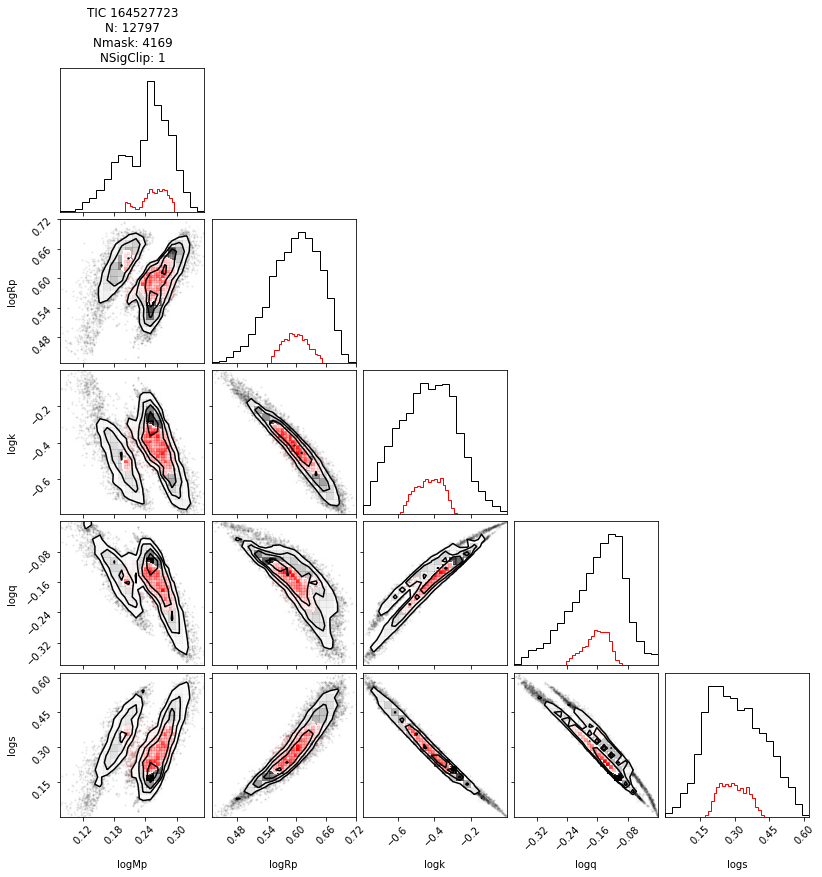

In [13]:

def load_all_data_for_pymc3_model(TIC_TARGET, sparse_factor=1, nsig=3):
    # TIC_TARGET = 'TIC 20215452'

    res, blsres, sysapodat = get_system_data_for_pymc3_model(TIC_TARGET)

    sys_dest, fig_dest = check_for_system_directory(TIC_TARGET, return_directories=True)
    M1R1_mu, M1R1_cov, logk_mu, logk_sig, logr1_mu, logr1_sig, logs_mu, logs_sig, MVpriorDat = get_M1_R1_from_binary_model(
        TIC_TARGET, nsig=nsig, fig_dest=fig_dest)
    
    rv_time = astropy.time.Time(sysapodat['JD'], format='jd', scale='tcb')
    # print(sysapodat['MJD'])
    texp = get_texp_from_lightcurve(res)

    x_rv = rv_time.btjd
    y_rv = sysapodat['VHELIO'] - res['joker_param']['MAP_v0']
    yerr_rv = sysapodat['CALIB_VERR']


    model_lk_data = res['lk_coll'].stitch(corrector_func=lambda x: x.remove_nans().normalize())
    x =    model_lk_data.remove_nans().time.btjd
    y =    model_lk_data.remove_nans().flux.value
    yerr = model_lk_data.remove_nans().flux_err.value

    x_lk_ref = min(x)

    x_rv = x_rv - x_lk_ref

    x = x - x_lk_ref 

    yerr = 1e3*(yerr / np.median(y))
    y = (y / np.median(y) - 1)

    y *= 1e3


    def run_with_sparse_data(x,y,yerr, use_sparse_data=False, sparse_factor=5):
        if use_sparse_data:
            np.random.seed(68594)
            m = np.random.rand(len(x)) < 1.0 / sparse_factor
            x = x[m]
            y = y[m]
            yerr = yerr[m]
        return x,y,yerr

    x,y,yerr = run_with_sparse_data(x,y,yerr,True, sparse_factor=sparse_factor)


    x = np.ascontiguousarray(x, dtype=np.float64)
    y = np.ascontiguousarray(y, dtype=np.float64)
    yerr = np.ascontiguousarray(yerr, dtype=np.float64)


    x_rv = np.ascontiguousarray(x_rv, dtype=np.float64)
    y_rv = np.ascontiguousarray(y_rv, dtype=np.float64)
    yerr_rv = np.ascontiguousarray(yerr_rv, dtype=np.float64)

    bls_period = blsres['period_at_max_power'].value
    print(blsres['t0_at_max_power'].btjd-x_lk_ref)
    bls_t0 = blsres['t0_at_max_power'].btjd - x_lk_ref
    print('lightcurve N datapoints: ',len(x),len(y),len(yerr), 'transit_epoch: ',bls_t0)


#     apo_period = jk_row['MAP_P'].value
#     apo_t0 = map_t0 = astropy.time.Time(res['joker_param']['MAP_t0_bmjd'], format='mjd', scale='tcb').btjd

    lit_period = bls_period  #bls_period      ### THESE ARE THE TWO VARIABLES USED
    lit_t0 = bls_t0   #bls_t0             ### IN THE PYMC3 MODEL BELOW


    transit_mask = model_lk_data.create_transit_mask(
        period=blsres['period_at_max_power'].value,
        duration=5*blsres['duration_at_max_power'].value,
        transit_time=blsres['t0_at_max_power']
    )

    no_transit_lks = model_lk_data[~transit_mask]
    y_masked = 1000 * (no_transit_lks.flux.value / np.median(no_transit_lks.flux.value) - 1)
    lk_sigma = np.std(y_masked)
    print(lk_sigma)

    Ntrans = np.floor((x.max() - lit_t0) / lit_period)
    print(Ntrans)
    lit_tn = lit_t0  + Ntrans * lit_period

    bls2res = highres_secondary_transit_bls(res,blsres)
    ecosw_tv = estimate_ecosw(bls2res, blsres)

    return {
        'texp' : texp,
        'x' : x,
        'y' : y,
        'yerr' : yerr,
        'x_rv' : x_rv,
        'y_rv' : y_rv,
        'lk_sigma' : lk_sigma,
        'yerr_rv' : yerr_rv,
        'lit_period' : lit_period,
        'lit_t0' : lit_t0,
        'Ntrans' : Ntrans,
        'lit_tn' : lit_tn,
        'ecosw_tv' : ecosw_tv,
        'isores' : {
            'logM1Q' : (M1R1_mu, M1R1_cov),
            'logR1' : (logr1_mu, logr1_sig),
            'logk' : (logk_mu, logk_sig),
            'logs' : (logs_mu, logs_sig),
            'MVdat': MVpriorDat
        }
    }


    
# bls_period, lit_period = popt[1], popt[1]
# bls_t0, lit_t0 = popt[-1]-x_lk_ref,popt[-1]-x_lk_ref
TIC_TARGET = "TIC 20215452"
pymc3_model_dict = load_all_data_for_pymc3_model("TIC 164527723", sparse_factor=10, nsig=1)


# bls_period, lit_period = popt[1], popt[1]
# bls_t0, lit_t0 = popt[-1]-x_lk_ref,popt[-1]-x_lk_ref

# fig,axes = plt.subplots(nrows=2, ncols=2,figsize=(20,15))
# # print(axes)
# axes[0][0].plot(
#     fold(x, lit_period, lit_t0), y, ".k"
# )

# axes[0][0].plot(
#     fold(no_transit_lks.time.value-x_lk_ref, lit_period, lit_t0),
#     y_masked, ",r"
# )

# axes[1][0].plot(
#     fold(x_rv, bls_period, bls_t0), y_rv, ".k",
#     label='folded with BLS'
# )
# axes[1][0].plot(
#     fold(x_rv, apo_period, apo_t0), y_rv, "+r",
#     label='folded with MAP'
# )

# axes[1][0].legend()
# axes[0][1].plot(x, y, ".k")
# axes[0][1].axvline(lit_t0, c='cyan')
# axes[0][1].axvline(lit_tn,c='cyan')
# axes[1][1].plot(x_rv-min(x_rv), y_rv, "+r")

# # x_rv = x_rv - lit_t0

# np.all(x_rv[1:] - x_rv[:-1] > 0.0)
# axes[1][0].axvline(0.0,ls='--',alpha=0.25)
# axes[1][0].axhline(0.0,ls='--',alpha=0.25)


# x1m, x1p = axes[0][0].set_xlim()
# axes[1][0].set_xlim(x1m,x1p)

In [14]:
def highres_secondary_transit_bls(res, blsres):
    
    jk_row = res['joker_param']

    
    dur_grid = np.exp(np.linspace(np.log(0.001),np.log(0.1),1000))
    
#     npts = 5000
#     pmin = period_grid.min()
#     pmax = period_grid.max()
#     mindur = dur_grid.min()

    all_lk = res['lk_coll'].stitch(corrector_func=lambda x: x.remove_nans().normalize().flatten())
    
    transit_mask = all_lk.create_transit_mask(
        period=blsres['period_at_max_power'].value,
        duration=5*blsres['duration_at_max_power'].value,
        transit_time=blsres['t0_at_max_power'].value
    )

    no_transit_lks = all_lk[~transit_mask]
        
#     print(f"Running BLS.")

#     maxtime = all_lk.time.max().value
#     mintime = all_lk.time.min().value

#     freq_f = int( ((pmin**-1 - pmax**-1) * (maxtime - mintime)**2) / (npts * mindur) ) 

    x = no_transit_lks.time
    y = no_transit_lks.flux
    yerr = no_transit_lks.flux_err

    cusBLS = astropy.timeseries.BoxLeastSquares(x, y, yerr)

    max_period = 100. * blsres['period_at_max_power'].value
    min_period = .011      #0.5 * jk_row['MAP_P']
    nf =   5 * 10**5    #5 * 10**5
    baseline = max(all_lk.time.value) - min(all_lk.time.value)
    
    min_f = 1. / max_period
    max_f = 1. / min_period
    
    freq_f = ( (max_f - min_f) * baseline**2. ) / ( (nf - 1) * min(dur_grid) )
    
    period_grid = np.array([blsres['period_at_max_power'].value])
                            #cusBLS.autoperiod(dur_grid, 
#                                     maximum_period = max_period,
#                                     minimum_period = min_period,
#                                     frequency_factor=freq_f)
    
#     print(nf, len(period_grid))
#     assert nf==len(period_grid)
    res = cusBLS.power(period_grid, dur_grid)

    maxpow = np.argmax(res['power'])
    cusBLSperiod = res['period'][maxpow]
    cusBLSt0 = res['transit_time'][maxpow]
    cusBLSdur = res['duration'][maxpow]
    cusBLSdepth = res['depth'][maxpow]

    res['period_at_max_power'] = cusBLSperiod
    res['t0_at_max_power'] = cusBLSt0
    res['depth_at_max_power'] = cusBLSdepth
    res['duration_at_max_power'] = cusBLSdur
    res['max_power'] = maxpow
    
    res['no_transit_lk'] = no_transit_lks
        
#     print("Finished.")

    

    
    return res

In [15]:
# # bls2res = highres_secondary_transit_bls(res,blsres)

# def estimate_ecosw(bls2res, blsres):
    
#     bls1_t0 = blsres['t0_at_max_power']
#     bls2_t0 = bls2res['t0_at_max_power']
#     print(bls2_t0, bls1_t0)
#     delT = (bls2_t0.value - bls1_t0.value) % blsres['period_at_max_power'].value
    
#     ecosw_testval = ( (np.pi/4.) * ( (2.*delT / blsres['period_at_max_power'].value) - 1) )
    
#     return ecosw_testval

# ecosw_tv = estimate_ecosw(bls2res, blsres)
# print(ecosw_tv)

### ecosw =  $\frac{\pi}{4}  \frac{2delT}{P} - 1$

In [18]:
def plot_MAP_rv_curve_diagnostic_plot(model, soln, extras, mask, 
                                        title='',
                                        DO_NOT_PLOT=True,
                                         RETURN_FILENAME=False,
                                      filename='',
                                     pymc3_model_dict=None):

    if mask is None:
        mask = np.ones(len(extras['x']), dtype=bool)
    
    if 'period' in soln.keys():
        period = soln['period']
    else:
        if pymc3_model_dict is not None:
            lit_tn = pymc3_model_dict['lit_tn']
            lit_t0 = pymc3_model_dict['lit_t0']
            Ntrans = pymc3_model_dict['Ntrans']

            period = (lit_tn - lit_t0) / Ntrans
        
    x_rv, y_rv, yerr_rv = pymc3_model_dict['x_rv'], pymc3_model_dict['y_rv'], pymc3_model_dict['yerr_rv']
    x, y, yerr = pymc3_model_dict['x'], pymc3_model_dict['y'], pymc3_model_dict['yerr']
        
    x = extras['x']
    y = extras['y']
    t_lc_pred = np.linspace(x.min(), x.max(), 3000) 
    
    t0 = soln['t0']
    mean = soln['mean_rv']
    x_phase = np.linspace(-0.5*period, 0.5*period, 1000)
    
#     x_rv = extras['x_rv']
#     y_rv = extras['y_rv']
    x_rv = extras['x_rv']
    y_rv = extras['y_rv']
    
    with model:
        gp_pred = (
            pmx.eval_in_model(extras["gp_lc_pred"], soln) + soln["mean_lc"]
        )
        lc = (
            pmx.eval_in_model(extras["model_lc"](x), soln)
            - soln["mean_lc"]
        )

        y_rv_mod = pmx.eval_in_model(extras['model_rv'](x_phase + t0), soln) - soln['mean_rv']
    
    # fig, axes = plt.subplots(nrows=3)
    gsfig = GridSpec(nrows=140,ncols=100)
    fig = plt.figure(figsize=(12,8), constrained_layout=False)

    fig, ax4 = plt.subplots(figsize=(12,18))

    ax1 = fig.add_subplot(gsfig[:30,:])
    ax2 = fig.add_subplot(gsfig[30:60,:])
    ax3 = fig.add_subplot(gsfig[70:100,:])
    ax4 = fig.add_subplot(gsfig[110:,:])
    
    ax1.tick_params(labelbottom=False,direction='in')
    ax2.tick_params(bottom=True,direction='in')

    ax1.plot(x, y, "k.", alpha=0.2)
    ax1.plot(x, gp_pred, color="C1", lw=1)
    ax1.plot(x,lc,'C2')

    ax1.set_xlim(x.min(),x.min()+np.ceil(period))# x.max())
    plt1_ylim = ax1.set_ylim()
#     ax1.set_xlim(x.max()-10,x.max())# x.max())

#     ax2.plot(x, y - gp_pred, "k.", alpha=0.2)
#     ax2.plot(x, lc, color="C2", lw=1)
    ax2.plot(x, y-lc, color='C1', lw=2)
    
    ax2.set_ylim(plt1_ylim[0],plt1_ylim[1])
    ax2.set_xlim(x.min(),x.min()+np.ceil(period))# x.max())
#     ax2.set_xlim(x.max()-10,x.max())# x.max())
    
    ax1.set_ylabel("raw flux [ppt]")
    ax2.set_ylabel("de-trended flux [ppt]")
    ax2.set_xlabel("time [TBJD]")



    x_fold = (
        (extras["x"] - t0) % period / period
    )
    inds = np.argsort(x_fold)

    ax3.plot(x_fold[inds], extras["y"][inds] - gp_pred[inds], "k.", alpha=0.2)
    ax3.plot(x_fold[inds] - 1, extras["y"][inds] - gp_pred[inds], "k.", alpha=0.2)
#     ax2.plot(
#         x_fold[mask][inds],
#         extras["y"][mask][inds] - gp_pred[mask][inds],
#         "k.",
#         alpha=0.2,
#         label="data!",
#     )
#     ax2.plot(x_fold[inds] - 1, extras["y"][inds] - gp_pred, "k.", alpha=0.2)

    yval = extras["y"][inds] - gp_pred
    bins = np.linspace(0, 1, 75)
    num, _ = np.histogram(x_fold[inds], bins, weights=yval)
    denom, _ = np.histogram(x_fold[inds], bins)
#     ax2.plot(0.5 * (bins[:-1] + bins[1:]) - 1, num / denom, ".w")

    args = dict(lw=1)

    x_fold = (x - t0) % period / period
    inds = np.argsort(x_fold)
    ax3.plot(x_fold[inds], lc[inds], "C2", **args)
    ax3.plot(x_fold[inds] - 1, lc[inds], "C2", **args)

    ax3.set_xlim(-1, 1)
    ax3.set_ylabel("de-trended flux [ppt]")
    ax3.set_xlabel("phase")
    
    x_rv_fold = fold(x_rv, period, t0)
    ax4.plot(x_phase, y_rv_mod, "C0")
    ax4.errorbar(x_rv_fold, y_rv-mean, yerr=np.sqrt(np.exp(2.*soln['log_sigma_rv']) + yerr_rv**2.),
                 fmt='.',c='black',ecolor='red', label='RV obs')
    ax4.set_title(title)
    
    y1,y2 = ax4.set_ylim()
    x1,x2 = ax4.set_xlim()
    ax4.vlines(0.25*(x2-x1) + x1,
               0.25*(y2-y1) + y1,
               0.25*(y2-y1) + y1 + np.exp(soln['log_sigma_rv'])
              )
    filename = filename + '.png'
    plt.savefig(filename, bbox_inches='tight', dpi=150)
    plt.close()
    
    if RETURN_FILENAME:
        return filename
    ax4.plot(x_rv_fold, y_rv-mean, ".", label='RV obs')
    ax4.set_title(title)
    fig_filename = f"/Users/kjaehnig/CCA_work/GAT/figs/diagnostic_{title.replace(' ','_')}_plot.png"
    plt.savefig(fig_filename, bbox_inches='tight', dpi=150)
    plt.close()
    
    if RETURN_FILENAME:
        return fig_filename

In [19]:
# def get_M1_R1_from_binary_model(TIC_TARGET):
#     from isochrones import BinaryStarModel

#     ID = TIC_TARGET.split(' ')[1]
#     mod = BinaryStarModel.load_hdf(f"/Users/kjaehnig/CCA_work/GAT/pymultinest_fits/tic_{ID}_binary_model_obj.hdf")
#     fig = corner(az.from_dict(mod.derived_samples[['mass_0','mass_1','radius_0','radius_1','Mbol_0','Mbol_1']].to_dict('list')))
#     m0,m1,r0,r1,mbol0,mbol1 = mod.derived_samples[['mass_0','mass_1','radius_0', 'radius_1','Mbol_0','Mbol_1']].values.T
    
#     num, denom = np.argmin([np.median(m0), np.median(m1)]), np.argmax([np.median(m0), np.median(m1)])
# #     mbol_0, mbol_1 = mod.derived_samples.Mbol_0.values,mod.derived_samples.Mbol_1.values
# #     num, denom = np.argmin([np.median(m0), np.median(m1)]), np.argmax([np.median(m0), np.median(m1)])
#     ms, mp = [m0,m1][num], [m0,m1][denom]

# #     num, denom = np.argmin([np.median(r0), np.median(r1)]), np.argmax([np.median(r0), np.median(r1)])
#     rs, rp = [r0,r1][num], [r0,r1][denom]
    
# #     num, denom = np.argmin([np.median(mbol0), np.median(mbol1)]), np.argmax([np.median(mbol0), np.median(mbol1)])
#     mbols,mbolp = [mbol0,mbol1][num], [mbol0,mbol1][denom]
    
#     mp_madSD = np.median(abs(mp - np.median(mp))) * 1.4826
#     rp_madSD = np.median(abs(rp - np.median(rp))) * 1.4826
#     mbp_madSD = np.median(abs(mbolp - np.median(mbolp))) * 1.4826
    
#     ms_madSD = np.median(abs(ms - np.median(ms))) * 1.4826
#     rs_madSD = np.median(abs(rs - np.median(rs))) * 1.4826
#     mbs_madSD = np.median(abs(mbols - np.median(mbols))) * 1.4826
    
#     nsig = 3.
#     mp_keep = abs(mp - np.median(mp)) < nsig * mp_madSD
#     rp_keep = abs(rp - np.median(rp)) < nsig * rp_madSD
#     mbp_keep = abs(mbolp - np.median(mbolp)) < nsig * mbp_madSD
    
#     ms_keep = abs(ms - np.median(ms)) < nsig * ms_madSD
#     rs_keep = abs(rs - np.median(rs)) < nsig * rs_madSD
#     mbs_keep = abs(mbols - np.median(mbols)) < nsig * mbs_madSD
    
    
#     cmplt_mask = (mp_keep) & (rp_keep) & (mbp_keep) & (ms_keep) & (rs_keep) & (mbs_keep)
#     fig.axes[0].set_title(TIC_TARGET + f"\nN: {cmplt_mask.shape[0]}" +f"\nNmask: {cmplt_mask.sum()}" + f"\nNSigClip: {int(nsig)}" )


#     corner(az.from_dict(mod.derived_samples[['mass_0','mass_1','radius_0','radius_1','Mbol_0','Mbol_1']][cmplt_mask].to_dict('list')), 
#            plot_contours=False, color='red', fig=fig, zorder=10)
    
#     plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/figs/{TIC_TARGET}_isochrones_BinFitCorner_w_sigmaclip.png",dpi=150, bbox_inches='tight')
    
#     m1 = mp[cmplt_mask]
#     r1 = rp[cmplt_mask]
#     log_k = np.log(rs / rp)[cmplt_mask]
#     log_q = np.log(ms / mp)[cmplt_mask]
#     log_s = np.log(mbols / mbolp)[cmplt_mask]

    
#     M1R1_mvPrior = np.array([
#                             m1,
#                              log_q
#                           ]
#                            )
    
#     M1R1_mu = np.mean(M1R1_mvPrior, axis=-1)
#     M1R1_cov = np.cov(M1R1_mvPrior)
    
    
#     return (M1R1_mu, M1R1_cov, np.mean(log_k), np.std(log_k), np.mean(np.log(r1)), np.std(np.log(r1)), np.mean(log_s), np.std(log_s))
    
# # M1R1_mu, M1R1_cov, logk_mu, logk_sig, logr1_mu, logr1_sig, logs_mu, logs_sig = get_M1_R1_from_binary_model("TIC 365204192") 
# # print(M1R1_mu)
# # print(M1R1_cov)
# # print(logk_mu, logk_sig)
# # print(lnk_sig)
# # print(lnq_sig)


There is already a directory for TIC 28159019.
0.001388888888888889 120.00000000000003
1.1389999999998963
lightcurve N datapoints:  10745 10745 10745 transit_epoch:  1.1389999999998963
3.3133538
165.0
There is already a directory for TIC 28159019.
scaled multivariate mean  [ 2.59554524e+00 -5.16488409e-04  3.04981100e+01 -3.15871999e+00]
original multivariate mean  [ 0.21593149  0.4812132  -0.12918958  0.21920562]
descaled multivariate mean  [ 0.21593149  0.4812132  -0.12918958  0.21920562]
the isotropized covariance matrix has a unit volume of 0.999999999999933
the raw covariance matrix has a unit volume of 5.895591812150534e-13
the diagonal covariance matrix has a unit volume of 1.0


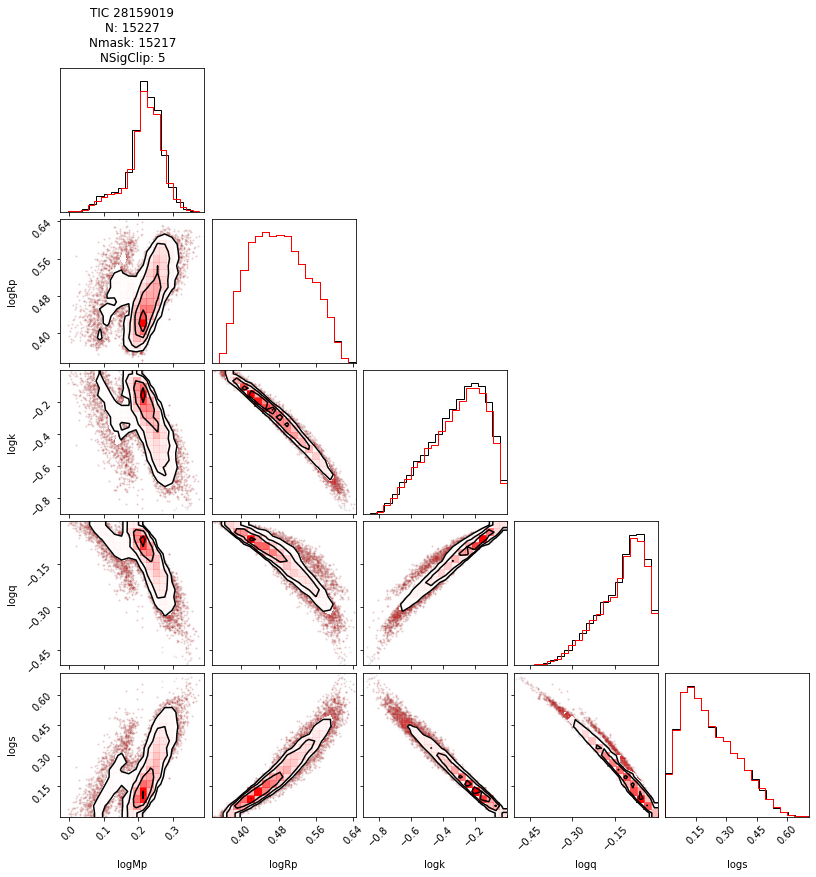

In [20]:
TIC_TARGET = "TIC 28159019"
COVARIANCE_USE_TYPE = 'isotropized'



pymc3_model_dict = load_all_data_for_pymc3_model(TIC_TARGET, sparse_factor=5, nsig=5)

tic_dest, fig_dest = check_for_system_directory(TIC_TARGET, return_directories=True)

texp = pymc3_model_dict['texp']
x_rv, y_rv, yerr_rv = pymc3_model_dict['x_rv'], pymc3_model_dict['y_rv'], pymc3_model_dict['yerr_rv']
x, y, yerr = pymc3_model_dict['x'], pymc3_model_dict['y'], pymc3_model_dict['yerr']
lk_sigma = pymc3_model_dict['lk_sigma']

lit_period, lit_t0, lit_tn = pymc3_model_dict['lit_period'], pymc3_model_dict['lit_t0'], pymc3_model_dict['lit_tn']
Ntrans, ecosw_tv = pymc3_model_dict['Ntrans'], pymc3_model_dict['ecosw_tv']

M1R1_mu, M1R1_cov = pymc3_model_dict['isores']['logM1Q']

if COVARIANCE_USE_TYPE == 'diagonal':
    M1R1_cov = np.zeros_like(M1R1_cov)
    suffix = 'diagonal_MV_prior'

    M1R1_cov[np.diag_indices(M1R1_cov.shape[0])] = 1.0

if COVARIANCE_USE_TYPE == 'isochrones':
    pass
    suffix = 'isochrones_MV_prior'
    
if COVARIANCE_USE_TYPE == 'isotropized':
    eVa, eVe = np.linalg.eig(M1R1_cov)
    R,S = eVe, np.diag(np.sqrt(eVa))
    T = R.dot(S).T
    Z = pymc3_model_dict['isores']['MVdat'].T.dot(np.linalg.inv(T))
    M1R1_scaled_cov = np.cov(Z.T)
    M1R1_scaled_mu = np.mean(Z.T, axis=-1)
    print("scaled multivariate mean ",M1R1_scaled_mu) 
    print("original multivariate mean ",M1R1_mu)
    print("descaled multivariate mean ",np.dot(M1R1_scaled_mu,T))

    suffix = 'isotropized_isochrones_MV_prior'
    
isotropized = M1R1_scaled_cov
eVa,eVe = np.linalg.eig(isotropized)
print(f"the isotropized covariance matrix has a unit volume of {np.product(eVa)}")

raw_isoCOV = pymc3_model_dict['isores']['logM1Q'][1]
eVa,eVe = np.linalg.eig(raw_isoCOV)
print(f"the raw covariance matrix has a unit volume of {np.product(eVa)}")

diagonalCOV = np.ndarray((4,4))
diagonalCOV[:] = 0.0
diagonalCOV[np.diag_indices(4)] = 1.0
eVa,eVe = np.linalg.eig(diagonalCOV)
print(f"the diagonal covariance matrix has a unit volume of {np.product(eVa)}")



In [21]:
# def get_isochrones_multivariate_dist(TIC_TARGET):
#     from isochrones import BinaryStarModel

#     ID = TIC_TARGET.split(' ')[1]
#     print(ID)
#     mod = BinaryStarModel.load_hdf(f"/Users/kjaehnig/CCA_work/GAT/pymultinest_fits/tic_{ID}_binary_model_obj.hdf")
#     m0,m1,r0,r1 = mod.derived_samples[['mass_0','mass_1','radius_0', 'radius_1']].values.T
    
#     mbol_0, mbol_1 = mod.derived_samples.Mbol_0.values,mod.derived_samples.Mbol_1.values

    
#     num,denom = np.argmin([m0.mean(),m1.mean()]), np.argmax([m0.mean(),m1.mean()])
# #     print(m0,m1,num,denom)
#     s =  [mbol_0,mbol_1][num] / [mbol_0,mbol_1][denom]
#     q = m0 / m1 # [m0,m1][num] / [m0,m1][denom]
#     k =r0 / r1 # [r0,r1][num] / [r0,r1][denom]
    
# #     print(m0,m1,mbol_0,mbol_1)
# #     m1, r1, q, k, s = ([m0,m1][denom],
# #                         [r0,r1][denom],
# #                         q,k,s
# #                        )
#     print(q.mean(), k.mean(), s.mean())
#     iso_multD = np.array([np.log([m0,m1][denom]), np.log([r0,r1][denom]), np.log(s)])

#     MV_mu = np.mean(iso_multD, axis=-1)
#     MV_cov = np.cov(iso_multD)
    
#     return (MV_mu, MV_cov)
# # m1, r1, q, k, s= get_isochrones_multivariate_dist("TIC 272074664")

# # MV_mu, MV_cov = get_isochrones_multivariate_dist(TIC_TARGET)
# print(MV_mu.T)
# print(np.round(MV_cov,4))
# print(np.isfinite(yerr_rv).sum(), yerr_rv.shape)
# np.log(np.median(yerr_rv))

## PYMC3 BUILD with a multivariate prior on M1, R1, Q, K, S

There is already a directory for TIC 28159019.
0.001388888888888889 120.00000000000003
1.1389999999998963
lightcurve N datapoints:  53182 53182 53182 transit_epoch:  1.1389999999998963
3.3133538
165.0
There is already a directory for TIC 28159019.
ecosw_tv:  -0.4592753693392572
[[ 0.00277399  0.00130136 -0.00303789  0.0041574 ]
 [ 0.00130136  0.00356958 -0.00453816  0.0075018 ]
 [-0.00303789 -0.00453816  0.00695537 -0.01083951]
 [ 0.0041574   0.0075018  -0.01083951  0.01741239]]
positive semi definiteness: True
[[0.00416098 0.         0.         0.        ]
 [0.         0.00535437 0.         0.        ]
 [0.         0.         0.01043306 0.        ]
 [0.         0.         0.         0.02611859]]
positive semi definiteness: True
sigma_lc ~ InverseGamma sigma_gp ~ InverseGamma rho_gp ~ InverseGamma
mean_lc                         -3.22
mean_rv                         -4.83
u1_quadlimbdark__               -2.77
u2_quadlimbdark__               -2.77
BigPrior                         5.78
l

optimizing logp for variables: [log_k]


message: Optimization terminated successfully.
logp: -8513868.229956688 -> -230936.23273800832
optimizing logp for variables: [b, log_k]


message: Desired error not necessarily achieved due to precision loss.
logp: -230936.23273800832 -> -228645.16405922768
optimizing logp for variables: [ecs]


message: Desired error not necessarily achieved due to precision loss.
logp: -228645.16405922768 -> -220030.2907092305
optimizing logp for variables: [tn, t0]


message: Optimization terminated successfully.
logp: -220030.2907092305 -> -217971.88728585886
optimizing logp for variables: [u2, u1]


message: Optimization terminated successfully.
logp: -217971.88728585886 -> -214662.69460905256
optimizing logp for variables: [rho_gp, sigma_gp, sigma_lc]


message: Optimization terminated successfully.
logp: -214662.69460905256 -> -179352.62298136827
optimizing logp for variables: [log_sigma_rv, mean_lc, mean_rv]


message: Optimization terminated successfully.
logp: -179352.62298136827 -> -130069.07498950427
optimizing logp for variables: [BigPrior]


message: Desired error not necessarily achieved due to precision loss.
logp: -130069.07498950427 -> -129176.19602877059
optimizing logp for variables: [log_sigma_rv, rho_gp, sigma_gp, sigma_lc, ecs, tn, t0, b, log_s, log_k, BigPrior, u2, u1, mean_rv, mean_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: -129176.19602877059 -> -126911.00609352639


##################################################
###################  FINISHED  ###################
##################################################


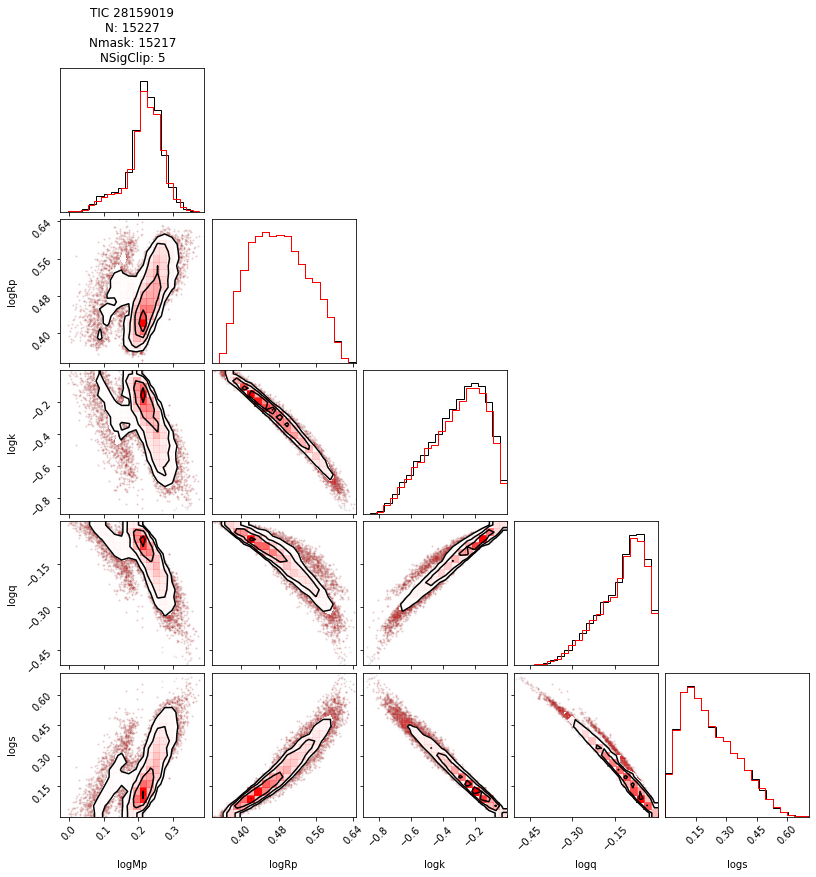

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

In [54]:
TIC_TARGET = "TIC 28159019"
COVARIANCE_USE_TYPE = 'diagonalized'

mult_factor = 1.5

pymc3_model_dict = load_all_data_for_pymc3_model(TIC_TARGET, sparse_factor=1, nsig=5)
tic_dest, fig_dest = check_for_system_directory(TIC_TARGET, return_directories=True)

texp = pymc3_model_dict['texp']
x_rv, y_rv, yerr_rv = pymc3_model_dict['x_rv'], pymc3_model_dict['y_rv'], pymc3_model_dict['yerr_rv']
x, y, yerr = pymc3_model_dict['x'], pymc3_model_dict['y'], pymc3_model_dict['yerr']
lk_sigma = pymc3_model_dict['lk_sigma']

lit_period, lit_t0, lit_tn = pymc3_model_dict['lit_period'], pymc3_model_dict['lit_t0'], pymc3_model_dict['lit_tn']
Ntrans, ecosw_tv = pymc3_model_dict['Ntrans'], pymc3_model_dict['ecosw_tv']
print('ecosw_tv: ', ecosw_tv)
if abs(ecosw_tv) > 0.05:
    ecosw_tv = np.sign(ecosw_tv) * 0.05

MV_mu, MV_cov = pymc3_model_dict['isores']['logM1Q']
print(MV_cov)
print(f"positive semi definiteness: {is_pos_def(MV_cov)}")

DIM = MV_cov.shape[0]


if COVARIANCE_USE_TYPE == 'diagonal':
    diag_cov = np.zeros_like(MV_cov)
    diag_cov[np.diag_indices(MV_cov.shape[0])] = 1.0
    pymc3_mu, pymc3_cov = MV_mu, diag_cov
    suffix = 'diagonal_MV_prior'


if COVARIANCE_USE_TYPE == 'isochrones':
    pymc3_mu, pymc3_cov = MV_mu, MV_cov
    suffix = 'isochrones_MV_prior'
    
if COVARIANCE_USE_TYPE == 'isotropized':
    eVa, eVe = np.linalg.eig(MV_cov)
    R,S = eVe, np.diag(np.sqrt(eVa))
    T = R.dot(S).T
    Z = pymc3_model_dict['isores']['MVdat'].T.dot(np.linalg.inv(T))
    sphr_cov = np.cov(Z.T)
    sphr_mu = np.mean(Z.T, axis=-1)
    pymc3_mu, pymc3_cov = sphr_mu, sphr_cov
    suffix = 'isotropized_isochrones_MV_prior'
    
if COVARIANCE_USE_TYPE == 'diagonalized':
    diagONLYcov = np.zeros_like(MV_cov)
    diagONLYcov[np.diag_indices(MV_cov.shape[0])] = MV_cov[np.diag_indices(MV_cov.shape[0])]
    pymc3_mu, pymc3_cov = MV_mu, diagONLYcov * mult_factor
    suffix = 'diagonalized_isochrones_MV_prior'

print(pymc3_cov)
print(f"positive semi definiteness: {is_pos_def(pymc3_cov)}")


M1R1_mu, M1R1_cov = pymc3_model_dict['isores']['logM1Q']
logr1_mu, logr1_sig = pymc3_model_dict['isores']['logR1']
logk_mu, logk_sig = pymc3_model_dict['isores']['logk']
logs_mu, logs_sig = pymc3_model_dict['isores']['logs']

trv = np.linspace(x_rv.min(), x_rv.max(), 5000)
tlc = np.linspace(x.min(), x.max(), 5000)

# rvK = xo.estimate_semi_amplitude(bls_period, x_rv, y_rv*u.km/u.s, yerr_rv*u.km/u.s, t0s=bls_t0)[0]
# print(rvK)

# mask = x < 400
def build_model(mask=None, start=None, plot_MAP_diagnostic_rv_curves=False):
    if mask is None:
        mask = np.ones(len(x), dtype='bool')
    with pm.Model() as model:

        # Systemic parameters
        mean_lc = pm.Normal("mean_lc", mu=0.0, sd=10.0)
        mean_rv = pm.Normal("mean_rv", mu=0.0, sd=50.0)

        u1 = xo.QuadLimbDark("u1")
        u2 = xo.QuadLimbDark("u2")

#         # Parameters describing the primary
#         log_M1 = pm.Normal("log_M1", 
#                            mu=np.log(isoM1), sigma=3.0, 
#                            testval=np.log(isoM1))
# #         log_R1 = pm.Uniform('log_R1', lower=np.log(1e-5), upper=np.log(1000))
#         log_R1 = pm.Normal("log_R1", 
#                            mu=np.log(isoR1), sigma=3.0, 
#                            testval=np.log(isoR1))

        BigPrior = pm.MvNormal("BigPrior",
                            mu = pymc3_mu,
                            cov = pymc3_cov,
                            shape=pymc3_cov.shape[0],
                            testval=pymc3_mu
                           )

        if COVARIANCE_USE_TYPE=='isotropized':
            descaled_BigPrior = tt.dot(BigPrior,T)
            M1 = pm.Deterministic("M1", tt.exp(descaled_BigPrior[0].squeeze()))
            R1 = pm.Deterministic("R1", tt.exp(descaled_BigPrior[1].squeeze()))
            q = pm.Deterministic("q", tt.exp(descaled_BigPrior[2].squeeze()))
            s = pm.Deterministic("s", tt.exp(descaled_BigPrior[3].squeeze()))
        else:
            M1 = pm.Deterministic("M1", tt.exp(BigPrior.T[0].squeeze()))
            R1 = pm.Deterministic("R1", tt.exp(BigPrior.T[1].squeeze()))
            q = pm.Deterministic("q", tt.exp(BigPrior.T[2].squeeze()))
            s = pm.Deterministic("s", tt.exp(BigPrior.T[3].squeeze()))
        
#         Secondary ratios
#         log_q = pm.Normal("log_q", mu=logq_mu, sigma=logq_sig, testval=logq_mu)  # mass ratio
#         log_s = pm.Normal("log_s", mu=logs_mu, sigma=1, testval = logs_mu)  # surface brightness ratio
#                             mu = M1R1_mu,
#                             cov = M1R1_cov,
#                             shape=3,
#                             testval=M1R1_mu
#                            )
#         M1R1_prior = pm.MvNormal('M1R1_prior',
#                       mu = M1R1_mu,
#                       cov = M1R1_cov,
#                       shape = (2),
#                       testval = M1R1_mu
#                      )
    
    
        


        
#         Secondary ratios
        log_k = pm.Normal("log_k", mu=logk_mu, sigma=logk_sig, testval=logk_mu)  # radius ratio        
#         log_q = pm.Normal("log_q", mu=logq_mu, sigma=logq_sig, testval=logq_mu)  # mass ratio
        log_s = pm.Normal("log_s", mu=logs_mu, sigma=logs_sig, testval = logs_mu)  # surface brightness ratio
#         log_R1 = pm.Normal("log_R1", mu=logr1_mu, sigma=logr1_sig, testval = logr1_mu)
#         ratio_prior = pm.MvNormal("ratio_prior",
#                                   mu = ratio_mu,
#                                   cov = ratio_cov,
#                                   shape = (2),
#                                   testval = ratio_mu
#                                     )
        

#         R1 = pm.Deterministic("R1", tt.exp(log_R1))
#         s = pm.Deterministic("s", tt.exp(log_s))
        k = pm.Deterministic("k", tt.exp(log_k))
#         M1 = pm.Deterministic("M1", tt.exp(BigPrior.T[0].squeeze()))
#         R1 = pm.Deterministic("R1", tt.exp(BigPrior.T[1].squeeze()))
# #         k = pm.Deterministic("k", tt.exp(ratio_prior.T[0].squeeze()))
#         q = pm.Deterministic("q", tt.exp(BigPrior.T[2].squeeze()))
# #         s = pm.Deterministic("s", tt.exp(BigPrior.T[3].squeeze()))
# #         R1 = pm.Deterministic("R1", tt.exp(log_R1))
#         s = pm.Deterministic("s", tt.exp(log_s))

        # Prior on flux ratio
#         pm.Normal(
#             "flux_prior",
#             mu=0.5,
#             sigma=0.25,
#             observed=tt.exp(2 * log_k + log_s),
#         )

        # Parameters describing the orbit
        b = xo.ImpactParameter("b", ror=tt.exp(log_k))
#         log_period = pm.Uniform(
#                 "log_period",
#                 lower=np.log(0.1),
#                 upper=np.log(3*lit_period),
#                 testval=np.log(lit_period)
#         )
            
#         log_period = pm.Normal("log_period", mu=np.log(lit_period), sigma=5.0)
#         period = pm.Deterministic("period", tt.exp(log_period))
        t0 = pm.Normal("t0", mu=lit_t0, sigma=1.0)
        tn = pm.Normal("tn", mu=lit_tn, sigma=1.0)
        period = pm.Deterministic("period", (tn - t0) / Ntrans)
        # Parameters describing the eccentricity: ecs = [e * cos(w), e * sin(w)]
#         ecosw_tv=0.01
        sqrt_ecosw = np.sign(ecosw_tv) * np.sqrt(abs(ecosw_tv))
        # ecs is now sqrt(ecs) even if variable name is still ecs
        ecs = pmx.UnitDisk("ecs", testval=np.array([sqrt_ecosw, 0.0]))
        # remove sqrt from ecc, rewrite as ecosW and esinW
        
        
        
        ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))

        # Build the orbit
#         R2 = pm.Deterministic("R2", tt.exp(log_k) * R1)
#         M2 = pm.Deterministic("M2", tt.exp(log_q) * M1)
        R2 = pm.Deterministic("R2", tt.exp(log_k) * R1)
        M2 = pm.Deterministic("M2", q * M1)
        
        orbit = xo.orbits.KeplerianOrbit(
            period=period,
            t0=t0,
            ecc=ecc,
            omega=omega,
            b=b,
            r_star=R1,
            m_star=M1,
            m_planet=M2,
        )

        # Track some other orbital elements
        pm.Deterministic("incl", orbit.incl)
        pm.Deterministic("a", orbit.a)
        
        
        
        
        # Noise model for the light curve
        
        
        
        sigma_lc = pm.InverseGamma(
            "sigma_lc",
            testval= np.mean(yerr),
            **pmx.estimate_inverse_gamma_parameters(0.1,5.0)
        )
        
        
        sigma_gp = pm.InverseGamma(
            "sigma_gp",
            testval= lk_sigma,
            **pmx.estimate_inverse_gamma_parameters(0.1,10.0),
        )
        rho_gp = pm.InverseGamma(
            "rho_gp",
            testval= 2.0 * lit_period,
            **pmx.estimate_inverse_gamma_parameters(0.1,10.0)
        )
#         sigma_lc = np.mean(yerr)
#         sigma_gp = lk_sigma
#         rho_gp = 0.25*lit_period
        print(sigma_lc, sigma_gp, rho_gp)
        kernel_lc = terms.SHOTerm(sigma=sigma_gp, rho=rho_gp, Q=1.0 / 3.)

#         # Noise model for the radial velocities
#         sigma_rv = pm.InverseGamma(
#             "sigma_rv",
#             testval=1.0,
#             **pmx.estimate_inverse_gamma_parameters(0.1, 15.0)
#         )
#         sigma_rv_gp = pm.InverseGamma(
#             "sigma_rv_gp",
#             testval=1.0,
#             **pmx.estimate_inverse_gamma_parameters(0.1, 15.0)
#         )
#         rho_rv_gp = pm.InverseGamma(
#             "rho_rv_gp",
#             testval=2.0,
#             **pmx.estimate_inverse_gamma_parameters(0.1, 25.0)
#         )
#         kernel_rv = terms.SHOTerm(sigma=sigma_rv_gp, w0=rho_rv_gp, Q=1.0 / 3.)

        # Set up the light curve model
        lc = xo.SecondaryEclipseLightCurve(u1, u2, s)

        def model_lc(t):
            return (
                mean_lc
                + 1e3
                * lc.get_light_curve(orbit=orbit, r=R2, t=t, texp=texp)[:,0]
            )

#         pm.Deterministic(
#             "lc_pred",
#             model_lc(tlc)
#         )
        
        # Condition the light curve model on the data
        gp_lc = GaussianProcess(kernel_lc, t=x[mask], yerr=sigma_lc)
        gp_lc.marginal("obs_lc", observed=y[mask] - model_lc(x[mask]))

#         gp_pred = pm.Deterministic("gp_pred",gp_lc.predict(y[mask] - model_lc(x[mask])))
#         # Set up the radial velocity model


        log_sigma_rv = pm.Normal(
            "log_sigma_rv", mu=np.log(np.median(yerr_rv)), sd=10., testval=np.log(np.median(yerr_rv))
        )

        def model_rv(t):
            return orbit.get_radial_velocity(t, output_units=u.km/u.s) + mean_rv
            
        rv_model = model_rv(x_rv)
        
#         def model_K(t, period, t0):
#             rvs = model_rv(t)
#             modK = xo.estimate_semi_amplitude(period, t, rvs, yerr_rv, t0).to(u.km/u.s)
#             return modK
#         rv_pred = pm.Deterministic('rv_pred', model_rv(trv))
    
        err = tt.sqrt(yerr_rv**2. + tt.exp(2*log_sigma_rv))
        
        pm.Normal("obs",mu=rv_model, sd=err, observed=y_rv)

        
#         ## compute phased RV signal
#         n = 2.*np.pi * (1./period)
#         phi = (t0 * n) - omega
#         phase = np.linspace(0, 1, 500)
#         M_pred = 2 * np.pi * phase - (phi)
#         f_pred = xo.orbits.get_true_anomaly(M_pred, ecc + tt.zeros_like(M_pred))
        
# #         K = xo.estimate_semi_amplitude(period, t, rv_model, yerr_rv, t0).to(u.km/u.s)
#         K = (tt.max(rv_model) - tt.min(rv_model)) / 2.
    
#         rvphase = pm.Deterministic(
#             "rvphase", K * (tt.cos(omega) * (tt.cos(f_pred) + ecc) - tt.sin(omega) * tt.sin(f_pred))
#         )
        
        # Optimize the logp
        if start is None:
            start = model.test_point

            
        extras = dict(
            x=x[mask],
            y=y[mask],
            x_rv = x_rv,
            y_rv = y_rv,
            model_lc=model_lc,
            model_rv=model_rv,
            gp_lc_pred=gp_lc.predict(y[mask] - model_lc(x[mask])),
        )
        
        
        # First the RV parameters
        print(model.check_test_point())
        opti_logp = []
        filename_list = []
        
        filename_base = f"{fig_dest}{TIC_TARGET.replace(' ','_')}_{suffix}"
        
        plot = plot_MAP_rv_curve_diagnostic_plot(model, start, extras, mask, 
                                                 title=' after start point opt step',
                                                 filename=filename_base + ' after start point opt step'.replace(' ','_'),
                                                 RETURN_FILENAME=True, pymc3_model_dict=pymc3_model_dict)
        filename_list.append(plot)
        
        map_soln, info_ = pmx.optimize(start, log_k, return_info=True)
        plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, 
                                                 title='after log_k opt step',
                                                 filename=filename_base + 'after log_k opt step.png'.replace(' ','_'),
                                                 RETURN_FILENAME=True, pymc3_model_dict=pymc3_model_dict)
        filename_list.append(plot)
        
        map_soln, info_ = pmx.optimize(map_soln, b, return_info=True)
        plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, 
                                                 title=' after b opt step',
                                                 filename = filename_base + ' after b opt step'.replace(' ','_'),
                                                 RETURN_FILENAME=True, pymc3_model_dict=pymc3_model_dict)
        filename_list.append(plot)
        
        map_soln, info_ = pmx.optimize(map_soln, ecs, return_info=True)
        plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, 
                                                 title='model after [ecs] opt step',
                                                 filename=filename_base + ' model after [ecs] opt step'.replace(' ','_'),
                                                 RETURN_FILENAME=True, pymc3_model_dict=pymc3_model_dict)
        ecs_logp = -info_['fun']
        filename_list.append(plot)
        
        
#         map_soln, info_ = pmx.optimize(map_soln, log_R1, return_info=True)
#         plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, title=f'RVs after log_R1 opt step',RETURN_FILENAME=True)
#         filename_list.append(plot)    
#         map_soln, info_ = pmx.optimize(map_soln, ratio_prior, return_info=True)
#         plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, title=f'RVs after ratio prior opt step', RETURN_FILENAME=True)
#         filename_list.append(plot)  
        

#         map_soln, info_ = pmx.optimize(map_soln, log_q, return_info=True)
#         plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, title=f'RVs after log_q opt step', RETURN_FILENAME=True)
#         filename_list.append(plot)
        

        
        map_soln, info_ = pmx.optimize(map_soln, [t0,tn], return_info=True)
        plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, 
                                                 title='after [tn,t0] opt step', 
                                                 filename = filename_base + ' after [tn,t0] opt step'.replace(' ','_'),
                                                 RETURN_FILENAME=True, pymc3_model_dict=pymc3_model_dict)
        filename_list.append(plot) 

        map_soln, info_ = pmx.optimize(map_soln, [u1,u2], return_info=True)
        plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, 
                                                 title=' after [u1, u2] opt step', 
                                                 filename=filename_base + ' after [u1, u2] opt step'.replace(' ','_'),
                                                 RETURN_FILENAME=True, pymc3_model_dict=pymc3_model_dict)
        filename_list.append(plot)
        
        map_soln, info_ = pmx.optimize(map_soln, [sigma_lc, sigma_gp, rho_gp], return_info=True)
        plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, 
                                                 title=' after GP params opt step',
                                                 filename=filename_base + ' after GP params opt step'.replace(' ','_'),
                                                 RETURN_FILENAME=True, pymc3_model_dict=pymc3_model_dict)
        filename_list.append(plot)
        
        map_soln, info_ = pmx.optimize(map_soln, [mean_rv,mean_lc,log_sigma_rv], return_info=True)
        plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, 
                                                 title=' after [mean_lc, mean_rv, log_sigma_rv] opt step',
                                                 filename=filename_base+' after [mean_lc, mean_rv, log_sigma_rv] opt step'.replace(' ','_'),
                                                 RETURN_FILENAME=True, pymc3_model_dict=pymc3_model_dict)
        filename_list.append(plot)


     

        if ~np.isfinite(ecs_logp):
            map_soln, info_ = pmx.optimize(map_soln, ecs, return_info=True)
            plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, 
                                                title=' after [ecs] opt step',
                                                filename=filename_base + ' after [ecs] opt step'.replace(' ','_'),
                                                 RETURN_FILENAME=True, pymc3_model_dict=pymc3_model_dict)
            filename_list.append(plot) 
            

        
        map_soln, info_ = pmx.optimize(map_soln, [BigPrior], return_info=True)
        plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, 
                                                 title=' after BigPriors opt step',
                                                 filename=filename_base + ' after BigPriors opt step'.replace(' ','_'),
                                                 RETURN_FILENAME=True, pymc3_model_dict=pymc3_model_dict)
        filename_list.append(plot)         

#         map_soln, info_ = pmx.optimize(map_soln, log_sigma_rv, return_info=True)
#         plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, 
#                                                  title=' after [log_sigma_rv] opt step',
#                                                  filename=filename_base + ' after [log_sigma_rv] opt step'.replace(' ','_'),
#                                                  RETURN_FILENAME=True, pymc3_model_dict=pymc3_model_dict)
#         filename_list.append(plot)

        
        map_soln, info_ = pmx.optimize(map_soln, 
#                                        [log_sigma_rv, rho_gp, sigma_gp, sigma_lc, ecs, tn, t0, b, log_k, log_s, BigPrior, u2, u1, mean_rv, mean_lc],
                                       return_info=True)
        plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, 
                                                 title=' after final opt step',
                                                 filename=filename_base+' after final opt step'.replace(' ','_'),
                                                 RETURN_FILENAME=True, pymc3_model_dict=pymc3_model_dict)
        filename_list.append(plot) 


    return model, map_soln, extras, start, opti_logp, filename_list




model, map_soln, extras, start, opti_logp, filename_list = build_model(plot_MAP_diagnostic_rv_curves=True)

import imageio
images = []

filename_list.append(filename_list[-1])
filename_list.append(filename_list[-1])
filename_list.append(filename_list[-1])
filename_list.append(filename_list[-1])
for filename in filename_list:
    images.append(imageio.imread(filename))
imageio.mimsave(tic_dest+f"/{TIC_TARGET.replace(' ','_')}_{suffix}__diagnostic_movie_test.gif", images, fps=0.75)
imageio.mimsave(f'/Users/kjaehnig/CCA_work/GAT/figs/{TIC_TARGET}_multivariate_prior_diagnostic_movie_test.gif', images, fps=0.75)

print("#" * 50)
print("#"*19 +"  FINISHED  " + "#"*19)
print("#"*50)

{'mean_lc': array(0.), 'mean_rv': array(0.), 'u1_quadlimbdark__': array([4.4408921e-16, 0.0000000e+00]), 'u2_quadlimbdark__': array([4.4408921e-16, 0.0000000e+00]), 'BigPrior': array([ 0.21593149,  0.4812132 , -0.12918958,  0.21920562]), 'log_k': array(-0.30921378), 'log_s': array(0.21920562), 'b_impact__': array(-0.90342742), 't0': array(1.139), 'tn': array(763.2109654), 'ecs_unitdisk+interval__': array([-0.45489907,  0.        ]), 'sigma_lc_log__': array(1.06346945), 'sigma_gp_log__': array(1.1979609), 'rho_gp_log__': array(2.2232427), 'log_sigma_rv': array(-1.21106004)}


<Figure size 864x576 with 0 Axes>

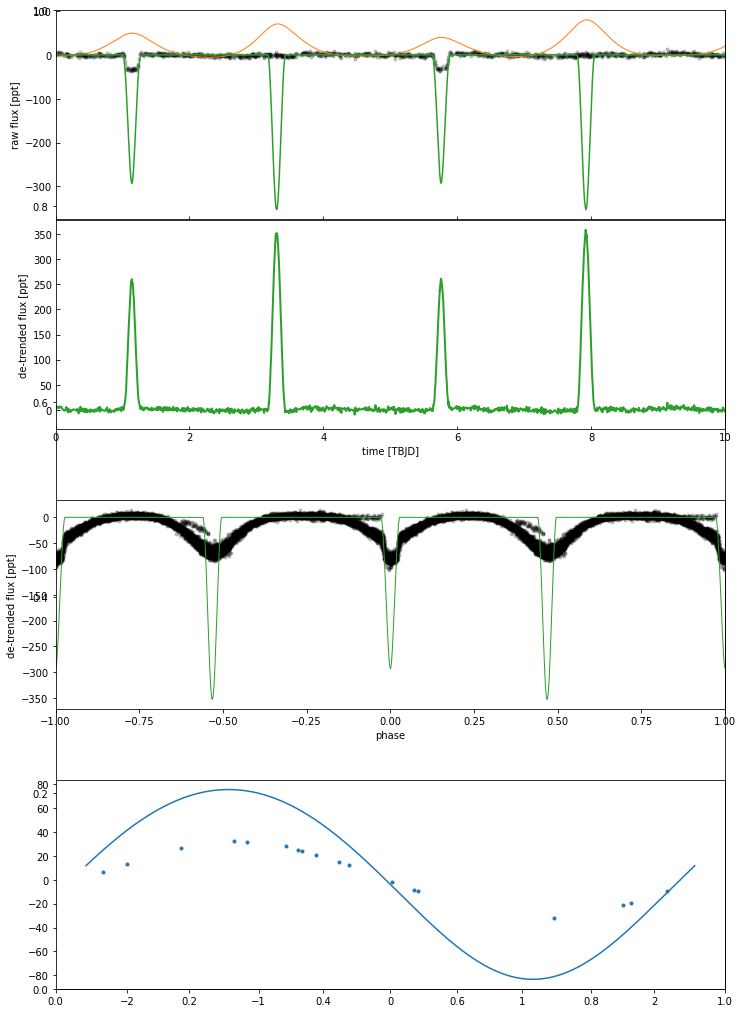

In [33]:
def plot_diagnostic_plots(soln, extras, mask, title,
                                        DO_NOT_SAVE=True):
    if mask is None:
        mask = np.ones(len(extras['x']), dtype=bool)
    
    if 'period' in soln.keys():
        period = soln['period']
    else:
        period = (soln['tn'] - soln['t0']) / Ntrans
    x = extras['x']
    y = extras['y']
    t_lc_pred = np.linspace(x.min(), x.max(), 3000) 
    
    t0 = soln['t0']
    mean = soln['mean_rv']
    x_phase = np.linspace(-0.5*period, 0.5*period, 1000)
    
    x_rv = extras['x_rv']
    y_rv = extras['y_rv']
    
    with model:
        gp_pred = (
            pmx.eval_in_model(extras["gp_lc_pred"], soln) + soln["mean_lc"]
        )
        lc = (
            pmx.eval_in_model(extras["model_lc"](x), soln)
            - soln["mean_lc"]
        )

        y_rv_mod = pmx.eval_in_model(extras['model_rv'](x_phase + t0), soln) - soln['mean_rv']
    
    # fig, axes = plt.subplots(nrows=3)
    gsfig = GridSpec(nrows=140,ncols=100)
    fig = plt.figure(figsize=(12,8), constrained_layout=False)

    fig, ax4 = plt.subplots(figsize=(12,18))

    ax1 = fig.add_subplot(gsfig[:30,:])
    ax2 = fig.add_subplot(gsfig[30:60,:])
    ax3 = fig.add_subplot(gsfig[70:100,:])
    ax4 = fig.add_subplot(gsfig[110:,:])
    
    ax1.tick_params(labelbottom=False,direction='in')
    ax2.tick_params(bottom=True,direction='in')

    ax1.plot(x, y, "k.", alpha=0.2)
    ax1.plot(x, gp_pred, color="C1", lw=1)
    ax1.plot(x,lc,'C2')

    ax1.set_xlim(x.min(),x.min()+10.)# x.max())
#     ax1.set_xlim(x.max()-10,x.max())# x.max())

#     ax2.plot(x, y - gp_pred, "k.", alpha=0.2)
#     ax2.plot(x, lc, color="C2", lw=1)
    ax2.plot(x, y-lc, color='C2', lw=2)
    
    ax2.set_xlim(x.min(),x.min()+10)# x.max())
#     ax2.set_xlim(x.max()-10,x.max())# x.max())
    
    ax1.set_ylabel("raw flux [ppt]")
    ax2.set_ylabel("de-trended flux [ppt]")
    ax2.set_xlabel("time [TBJD]")



    x_fold = (
        (extras["x"] - t0) % period / period
    )
    inds = np.argsort(x_fold)

    ax3.plot(x_fold[inds], extras["y"][inds] - gp_pred[inds], "k.", alpha=0.2)
    ax3.plot(x_fold[inds] - 1, extras["y"][inds] - gp_pred[inds], "k.", alpha=0.2)
#     ax2.plot(
#         x_fold[mask][inds],
#         extras["y"][mask][inds] - gp_pred[mask][inds],
#         "k.",
#         alpha=0.2,
#         label="data!",
#     )
#     ax2.plot(x_fold[inds] - 1, extras["y"][inds] - gp_pred, "k.", alpha=0.2)

    yval = extras["y"][inds] - gp_pred
    bins = np.linspace(0, 1, 75)
    num, _ = np.histogram(x_fold[inds], bins, weights=yval)
    denom, _ = np.histogram(x_fold[inds], bins)
#     ax2.plot(0.5 * (bins[:-1] + bins[1:]) - 1, num / denom, ".w")

    args = dict(lw=1)

    x_fold = (x - t0) % period / period
    inds = np.argsort(x_fold)
    ax3.plot(x_fold[inds], lc[inds], "C2", **args)
    ax3.plot(x_fold[inds] - 1, lc[inds], "C2", **args)

    ax3.set_xlim(-1, 1)
    ax3.set_ylabel("de-trended flux [ppt]")
    ax3.set_xlabel("phase")
    
    x_rv_fold = (x_rv - t0 + 0.5*period) % period - 0.5*period
    ax4.plot(x_phase, y_rv_mod, "C0")
    ax4.plot(fold(x_rv,period,t0), y_rv-mean, ".", label='RV obs')
    ax4.set_title(title)
    if DO_NOT_SAVE is False:
        plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/figs/diagnostic_{title.replace(' ','_')}_plot.png",
                bbox_inches='tight', dpi=150)
        plt.close()
    
plot_diagnostic_plots(start, extras, mask=None, title='',DO_NOT_SAVE=True),
print(start)

<Figure size 864x576 with 0 Axes>

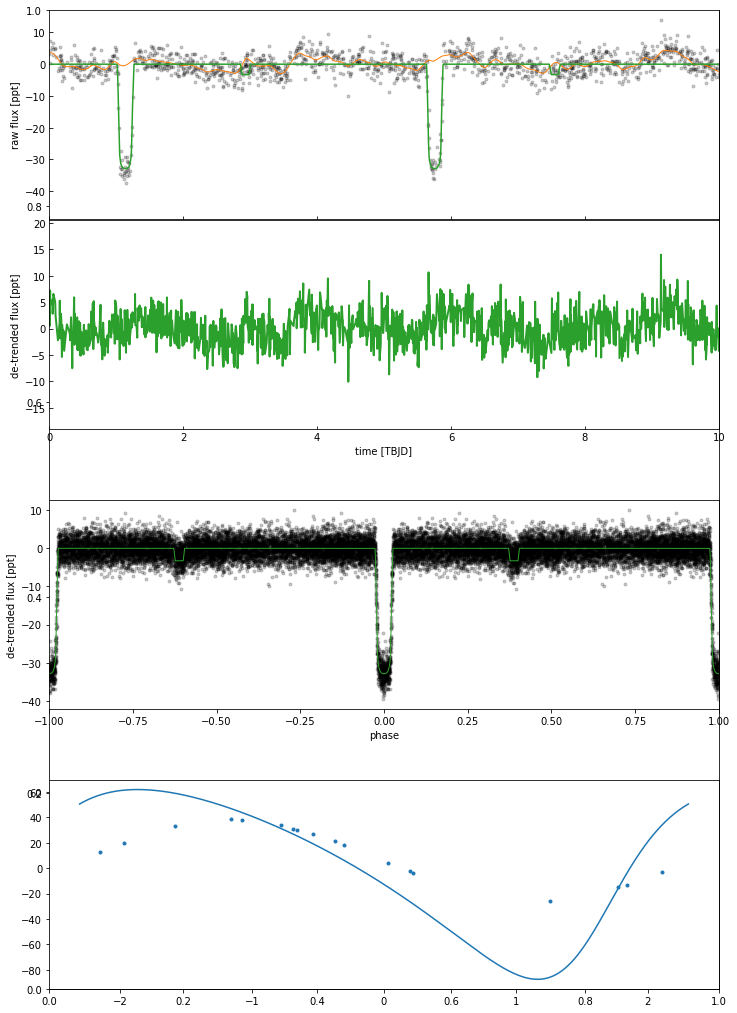

In [34]:
plot_diagnostic_plots(map_soln, extras, title='',mask=None)
plt.savefig("/Users/kjaehnig/CCA_work/GAT/figs/diagnostic_plot_after_brute_force_MAP.png",dpi=150, bbox_inches='tight')

/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_92162/3704187860.py:35: RuntimeWarning: invalid value encountered in double_scalars
  ax[0].scatter(xplt,(start[sname]-startext[sname])/start[sname],label=sname, ec=cmind[ii],marker=plot_mark,s=100,fc='None')
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_92162/3704187860.py:35: RuntimeWarning: invalid value encountered in true_divide
  ax[0].scatter(xplt,(start[sname]-startext[sname])/start[sname],label=sname, ec=cmind[ii],marker=plot_mark,s=100,fc='None')


--------------------------------------------------
not plotted: BigPrior


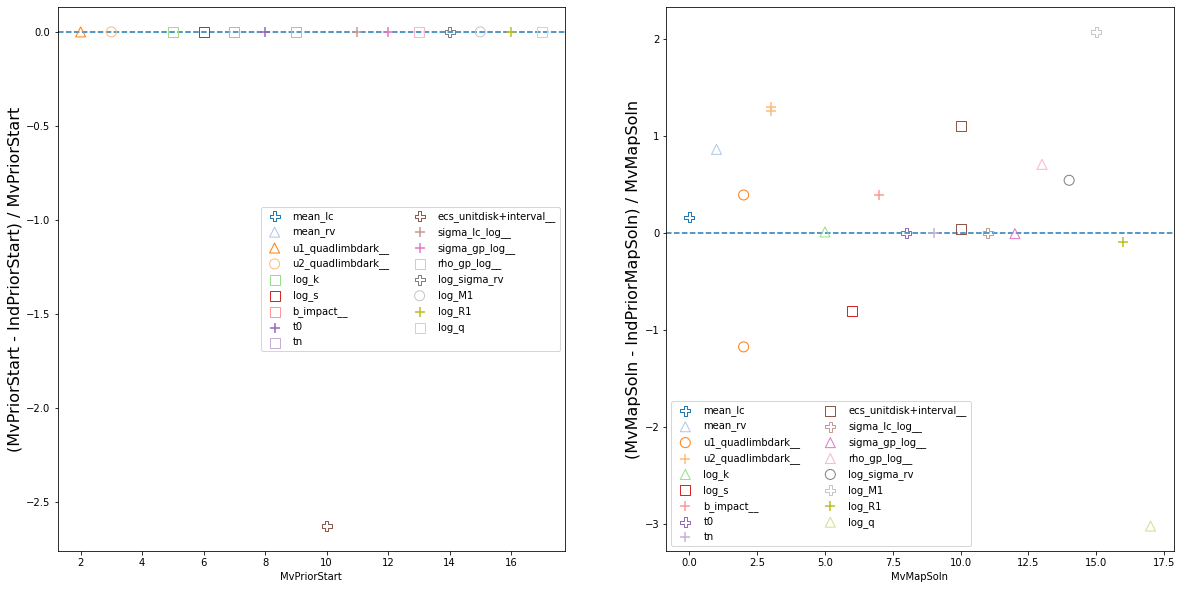

In [35]:
def plot_individual_map_solns_with_multivariate_map_solns(start, map_solns, TIC_TARGET):
    """
    [log_sigma_rv, rho_gp, sigma_gp, sigma_lc, ecs, tn, t0, b, log_s, log_q, log_k, log_R1, log_M1, u2, u1, mean_rv, mean_lc]
    """
    file = open(f"/Users/kjaehnig/CCA_work/GAT/{TIC_TARGET}_joint_mod_individual_priors_map_soln.pickle",'rb')
    ind_map_solns,startext = pk.load(file)
    file.close()
#     print(start.keys(), startext.keys())
    map_solns['log_M1'] = map_solns['BigPrior'][0]
    map_solns['log_R1'] = map_solns['BigPrior'][1]
    map_solns['log_q'] = map_solns['BigPrior'][2]
    map_solns['log_s'] = map_solns['BigPrior'][3]
    
    start['log_M1'] = start['BigPrior'][0]
    start['log_R1'] = start['BigPrior'][1]
    start['log_q'] = start['BigPrior'][2]
    start['log_s'] = start['BigPrior'][3]
    
#     soln_names = ['log_sigma_rv', 'rho_gp', 'sigma_gp', 'sigma_lc', 'ecs', 'tn', 't0', 'b', 'log_s', 'log_q', 'log_k', 'log_R1', 'log_M1', 'u2', 'u1', 'mean_rv', 'mean_lc']
#     soln_names = list(map_solns.keys())

    fig,ax = plt.subplots(figsize=(20,10),ncols=2)
    markers = ['o','^','s','+','P']
    cmind = plt.cm.tab20.colors
    
    for ii,sname in enumerate(start.keys()):
#         print(start[sname], startext[sname])
        try:
            plot_mark = markers[np.random.randint(low=0,high=5)]
            if sname in ['u1_quadlimbdark__','u2_quadlimbdark__','ecs_unitdisk+interval__']:
                xplt = [ii,ii]
            else:
                xplt = ii

            ax[0].scatter(xplt,(start[sname]-startext[sname])/start[sname],label=sname, ec=cmind[ii],marker=plot_mark,s=100,fc='None')

        except:
            pass
#             print(f'not plotted: {sname}')
            
    print('-'*50)
    for ii,sname in enumerate(start.keys()):
#         print(sname, sname in map_solns.keys(), sname in ind_map_solns.keys(), map_solns[sname])
        try:
            plot_mark = markers[np.random.randint(low=0,high=5)]
            if sname in ['u1_quadlimbdark__','u2_quadlimbdark__','ecs_unitdisk+interval__']:
                xplt = [ii,ii]
            else:
                xplt = ii
#             ax[0].scatter(xplt,(start[sname]-startext[sname])/start[sname],label=sname, ec=cmind[ii],marker=plot_mark,s=100,fc='None')
            ax[1].scatter(xplt,(map_solns[sname]-ind_map_solns[sname])/map_solns[sname],label=sname, ec=cmind[ii],marker=plot_mark,s=100,fc='None')

        except:
            pass
            print(f'not plotted: {sname}')
    ax[0].set_ylabel("(MvPriorStart - IndPriorStart) / MvPriorStart", fontsize=16)
    ax[0].set_xlabel("MvPriorStart")
    ax[1].set_ylabel("(MvMapSoln - IndPriorMapSoln) / MvMapSoln", fontsize=16)
    ax[1].set_xlabel("MvMapSoln")
#     ax.loglog(True)
#     x1,x2 = ax.set_xlim()
#     y1,y2 = ax.set_ylim()
#     ax.set_xscale('log')
#     ax.set_xlim(min(x1,y1), max(x2,y2))
#     ax.set_ylim(min(x1,y1), max(x2,y2))
#     ax.plot([min(x1,y1), max(x2,y2)],[min(x1,y1), max(x2,y2)],ls='--',zorder=-1)
#     ax[0].set_ylim(-1e-5,1e-5)
    ax[0].legend(fontsize=10, ncol=2, loc='best')
    ax[1].legend(fontsize=10, ncol=2, loc='best')
    ax[0].axhline(0.0,ls='--',zorder=-1)
    ax[1].axhline(0.0,ls='--',zorder=-1)
plot_individual_map_solns_with_multivariate_map_solns(start, map_soln, TIC_TARGET)
plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/figs/{TIC_TARGET}_start_map_solns_comprison.png",bbox_inches='tight')
# print(map_soln.keys())

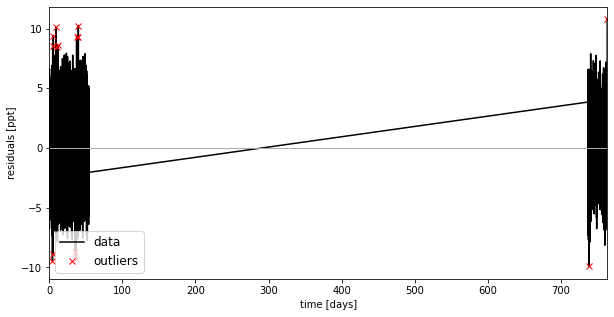

In [37]:
with model:
    mod = pmx.eval_in_model(
        extras['model_lc'](extras['x']) + extras['gp_lc_pred'],
        map_soln,
    )
    
resid = y - mod
rms = np.sqrt(np.median(resid ** 2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
_ = plt.xlim(x.min(), x.max())

sigma_lc ~ InverseGamma sigma_gp ~ InverseGamma rho_gp ~ InverseGamma
mean_lc                         -3.22
mean_rv                         -4.83
u1_quadlimbdark__               -2.77
u2_quadlimbdark__               -2.77
BigPrior                         6.60
log_k                            0.83
log_s                            1.11
b_impact__                      -1.58
t0                              -0.92
tn                              -0.92
ecs_unitdisk+interval__         -1.46
sigma_lc_log__                  -3.05
sigma_gp_log__                  -2.69
rho_gp_log__                    -4.11
log_sigma_rv                    -3.22
obs_lc                    -2006216.84
obs                         -44632.08
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [log_k]


message: Optimization terminated successfully.
logp: -26333.708224198017 -> -26333.686782835077


optimizing logp for variables: [b, log_k]


message: Optimization terminated successfully.
logp: -26333.686782835077 -> -26333.6647223904
optimizing logp for variables: [ecs]


message: Optimization terminated successfully.
logp: -26333.6647223904 -> -26333.66399285609
optimizing logp for variables: [tn, t0]


message: Optimization terminated successfully.
logp: -26333.66399285609 -> -26333.60457561822
optimizing logp for variables: [u2, u1]


message: Optimization terminated successfully.
logp: -26333.60457561822 -> -26333.582421351588
optimizing logp for variables: [rho_gp, sigma_gp, sigma_lc]


message: Optimization terminated successfully.
logp: -26333.582421351588 -> -26332.70026385312
optimizing logp for variables: [mean_lc, mean_rv]


message: Optimization terminated successfully.
logp: -26332.70026385312 -> -26332.69989440231
optimizing logp for variables: [log_sigma_rv]


message: Optimization terminated successfully.
logp: -26332.69989440231 -> -26332.69989394241


optimizing logp for variables: [BigPrior]


message: Desired error not necessarily achieved due to precision loss.
logp: -26332.69989394241 -> -26332.685226181842
optimizing logp for variables: [log_sigma_rv, rho_gp, sigma_gp, sigma_lc, ecs, tn, t0, b, log_s, log_k, BigPrior, u2, u1, mean_rv, mean_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: -26332.685226181842 -> -26164.233470343253


10745 10731


<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

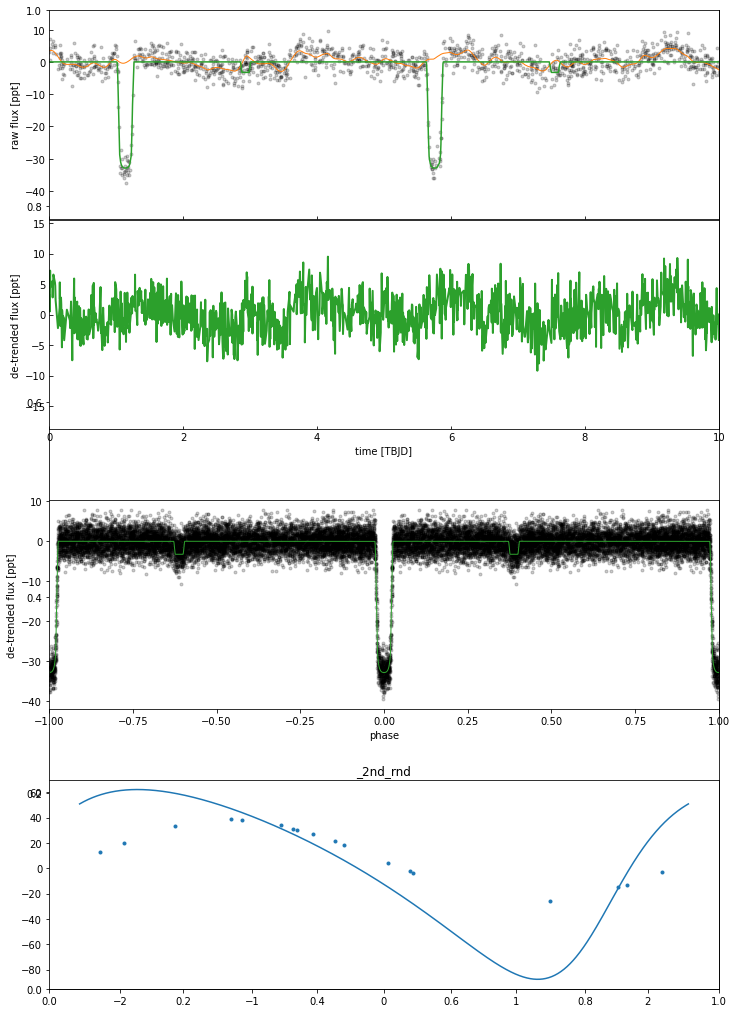

In [38]:
model, map_soln, extras, start, opti_logp,_ = build_model(mask, map_soln)
print(len(mask), len(extras['x']))
plot_diagnostic_plots(map_soln, extras, mask=None,title='_2nd_rnd')


In [41]:
Ntune = 1000
Ndraw = 500
chains = 4
with model:
    trace = pm.sample(
        tune=Ntune,
        draws=Ndraw,
        start=map_soln,
        # Parallel sampling runs poorly or crashes on macos
        cores=chains,
        chains=chains,
        target_accept=0.99,
        return_inferencedata=True,
        random_seed=[261136681, 261136682,261136683,261136684],#261136685, 261136686,261136687,261136688],
        init='jitter+adapt_full'
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma_rv, rho_gp, sigma_gp, sigma_lc, ecs, tn, t0, b, log_s, log_k, BigPrior, u2, u1, mean_rv, mean_lc]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 3557 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [42]:
from pymc3.util import get_default_varnames, get_untransformed_name, is_transformed_name
import theano

def compute_value_in_post(model, idata, target, size=None):
    # Get the names of the untransformed variables
    vars = get_default_varnames(model.unobserved_RVs, True)
    names = list(sorted(set([
        get_untransformed_name(v.name)
        if is_transformed_name(v.name)
        else v.name
        for v in vars
    ])))

    # Compile a function to compute the target
    func = theano.function([model[n] for n in names], target, on_unused_input="ignore")

    # Call this function for a bunch of values
    flat_samps = idata.posterior.stack(sample=("chain", "draw"))
    if size is None:
        indices = np.arange(len(flat_samps.sample))
    else:
        indices = np.random.randint(len(flat_samps.sample), size=size)

    return [func(*(flat_samps[n].values[..., i] for n in names)) for i in indices]

flat_samps = trace.posterior.stack(sample=('chain', 'draw')) #trace.posterior.stack(sample=("chain", "draw"))

rvvals = compute_value_in_post(model, trace, extras['model_rv'](trv), size=512)
lcvals = compute_value_in_post(model, trace, extras['model_lc'](tlc), size=512)

rvact = compute_value_in_post(model, trace, extras['model_rv'](x_rv), size=512)
lcact = compute_value_in_post(model, trace, extras['model_lc'](x), size=512)
# print(np.median(flat_samps['u1'],axis=-1))
# post_map_soln = {}
# post_map_soln['mean_lc'], post_map_soln['mean_rv'], post_map_soln['ecs_unitdisk+interval__'] = (
#     np.array(np.mean(flat_samps['mean_lc'])), np.array(np.mean(flat_samps['mean_rv'])), np.array(np.mean(flat_samps['ecs'],axis=-1))
# )
# post_map_soln['u1_quadlimbdark__'], post_map_soln['u2_quadlimbdark__'], post_map_soln['BigPrior'] = (
#     np.array(np.mean(flat_samps['u1'], axis=-1)), np.array(np.mean(flat_samps['u2'], axis=-1)), np.array(np.mean(flat_samps['BigPrior'], axis=-1))
# )
# post_map_soln['log_k'], post_map_soln['b_impact__'], post_map_soln['t0'], post_map_soln['tn']= (
#     np.array(np.mean(flat_samps['log_k'])), np.array(np.mean(flat_samps['b'])), 
#     np.array(np.mean(flat_samps['t0'])), np.array(np.mean(flat_samps['tn']))
# )
# post_map_soln['sigma_lc_log__'], post_map_soln['sigma_gp_log__'], post_map_soln['rho_gp_log__'] = (
#     np.array(np.log(np.mean(flat_samps['sigma_lc']))), np.array(np.log(np.mean(flat_samps['sigma_gp']))), 
#     np.array(np.log(np.mean(flat_samps['rho_gp'])))
# )
# post_map_soln['log_sigma_rv'] = np.array(np.mean(flat_samps['log_sigma_rv']))
# print(post_map_soln)
# post_map_soln['log_sigma_rv'], post_map_soln['log_M1'], post_map_soln['log_R1'] = (
#     np.median(flat_samps['log_sigma_rv']), np.log(np.median(flat_samps['M1'])), np.log(np.median(flat_samps['R1']))
# )
# post_map_soln['omega'], post_map_soln['incl'], post_map_soln['log_k'] = (
#     np.median(flat_samps['log_sigma_rv']), np.median(flat_samps['log_M1']), np.median(flat_samps['log_R1'])
# )
print(map_soln)
with model:
    gp_pred = (
        pmx.eval_in_model(extras["gp_lc_pred"], map_soln)
    )

{'mean_lc': array(0.30942214), 'mean_rv': array(-6.31890926), 'u1_quadlimbdark__': array([-1.02667392, -2.76239389]), 'u2_quadlimbdark__': array([-0.14081502, -0.05959062]), 'BigPrior': array([ 0.17825779,  0.54514381, -0.25998696, -2.21331554]), 'log_k': array(-1.75459372), 'log_s': array(0.21920561), 'b_impact__': array(-2.15019676), 't0': array(1.13915619), 'tn': array(763.23483142), 'ecs_unitdisk+interval__': array([-0.64583145, -1.02996088]), 'sigma_lc_log__': array(0.93074734), 'sigma_gp_log__': array(0.78926159), 'rho_gp_log__': array(-0.35032876), 'log_sigma_rv': array(3.23567045), 'u1': array([0.0609995 , 0.45254645]), 'u2': array([0.66149374, 0.0203085 ]), 'M1': array(1.19513337), 'R1': array(1.72485641), 'q': array(0.77106164), 's': array(0.10933753), 'k': array(0.17297751), 'b': array(0.12235661), 'period': array(4.61876167), 'ecs': array([-0.31214095, -0.45014276]), 'ecc': array(0.30006047), 'omega': array(-2.17709696), 'R2': array(0.29836136), 'M2': array(0.9215215), 'inc

In [101]:
file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/{TIC_TARGET}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_{suffix}.pickle",'wb')
pk.dump({'trace':trace,
         'mask':mask,
        'map_soln':map_soln,
        'model':model,
        'trv':trv,
        'tlc':tlc,
        'lcvals': lcvals,
        'rvvals': rvvals,
        'lcact': lcact,
        'rvact': rvact},
        file)


In [147]:
file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/{TIC_TARGET}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}.pickle",'wb')
pk.dump(trace,file)
file.close()

In [151]:
from corner import corner
_ = corner(trace, var_names=['M1','R1','q','s','k','b','period','log_sigma_rv','t0','tn','ecc', 'omega'], smooth=1, use_math_text=True,
          truths=[map_soln['M1'], map_soln['R1'], map_soln['q'], map_soln['s'], map_soln['k'], map_soln['b'], 
                  map_soln['period'], map_soln['log_sigma_rv'], 
                  map_soln['t0'], map_soln['tn'], map_soln['ecc'], map_soln['omega']],
            truth_color='red', range=[1,1,1,1,1,1,1,1,1,1,1,1])
_ = corner(trace, var_names=['M1','R1','q','log_s','log_k','b','ecs','log_sigma_rv','t0','tn','ecc', 'omega'], smooth=1, use_math_text=True,
          truths=[map_soln['M1'], map_soln['R1'], map_soln['q'], map_soln['log_s'], map_soln['log_k'], map_soln['b'], 
                  map_soln['ecs_unitdisk+interval__'][0],map_soln['ecs_unitdisk+interval__'][1], map_soln['log_sigma_rv'], 
                  map_soln['t0'], map_soln['tn'], map_soln['ecc'], map_soln['omega']],
            truth_color='red', range=[1,1,1,1,1,1,1,1,1,1,1,1,1])
plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/figs/{TIC_TARGET.replace(' ','_')}_joint_rv_lightcurve_corner_w_MVnormal_prior.png",bbox_inches='tight', dpi=150)

In [169]:
file = open("tic28159019_joint_mod_individual_priors_map_soln.pickle","rb")
individual_map_soln = pk.load(file)
file.close()
map_soln['log_M1'] = map_soln['BigPrior'][0]
map_soln['log_R1'] = map_soln['BigPrior'][1]
map_soln['log_q'] = map_soln['BigPrior'][2]

prior_names = ['log_sigma_rv', 'rho_gp', 'sigma_gp', 'sigma_lc', 'ecs', 'tn', 't0', 'b', 'log_s', 'log_k', 'BigPrior', 'u2', 'u1', 'mean_rv', 'mean_lc']

for solns in prior_names:
    if solns in individual_map_soln.keys():
        print(f"del {solns}:  {map_soln[solns]-individual_map_soln[solns]}")

In [47]:
from pymc3.util import get_default_varnames, get_untransformed_name, is_transformed_name
import theano

def compute_value_in_post(model, idata, target, size=None):
    # Get the names of the untransformed variables
    vars = get_default_varnames(model.unobserved_RVs, True)
    names = list(sorted(set([
        get_untransformed_name(v.name)
        if is_transformed_name(v.name)
        else v.name
        for v in vars
    ])))

    # Compile a function to compute the target
    func = theano.function([model[n] for n in names], target, on_unused_input="ignore")

    # Call this function for a bunch of values
    flat_samps = idata.posterior.stack(sample=("chain", "draw"))
    if size is None:
        indices = np.arange(len(flat_samps.sample))
    else:
        indices = np.random.randint(len(flat_samps.sample), size=size)

    return [func(*(flat_samps[n].values[..., i] for n in names)) for i in indices]


rvvals = compute_value_in_post(model, trace, extras['model_rv'](trv), size=512)
lcvals = compute_value_in_post(model, trace, extras['model_lc'](tlc), size=512)

print(np.shape(rvvals), np.shape(lcvals))
# inds = np.argsort(foldedtrv)
# for ii in range(1000):
#     axes.plot(foldedtrv,rvals[ii],'.r',alpha=0.1)
# axes.hist(rvals)
print(np.percentile(rvvals, [16,50,84],axis=0).shape)

xo.utils.docs_setup()

file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/{TIC_TARGET}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_{suffix}.pickle",'rb')
indres = pk.load(file)
file.close()

print(np.percentile(rvvals, [16,50,84],axis=0).shape)

(512, 5000) (512, 5000)
(3, 5000)
(3, 5000)


<xarray.DataArray 'ecc' ()>
array(0.26718909)
<xarray.DataArray 'ecc' ()>
array(0.26718909)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Liberation Sans


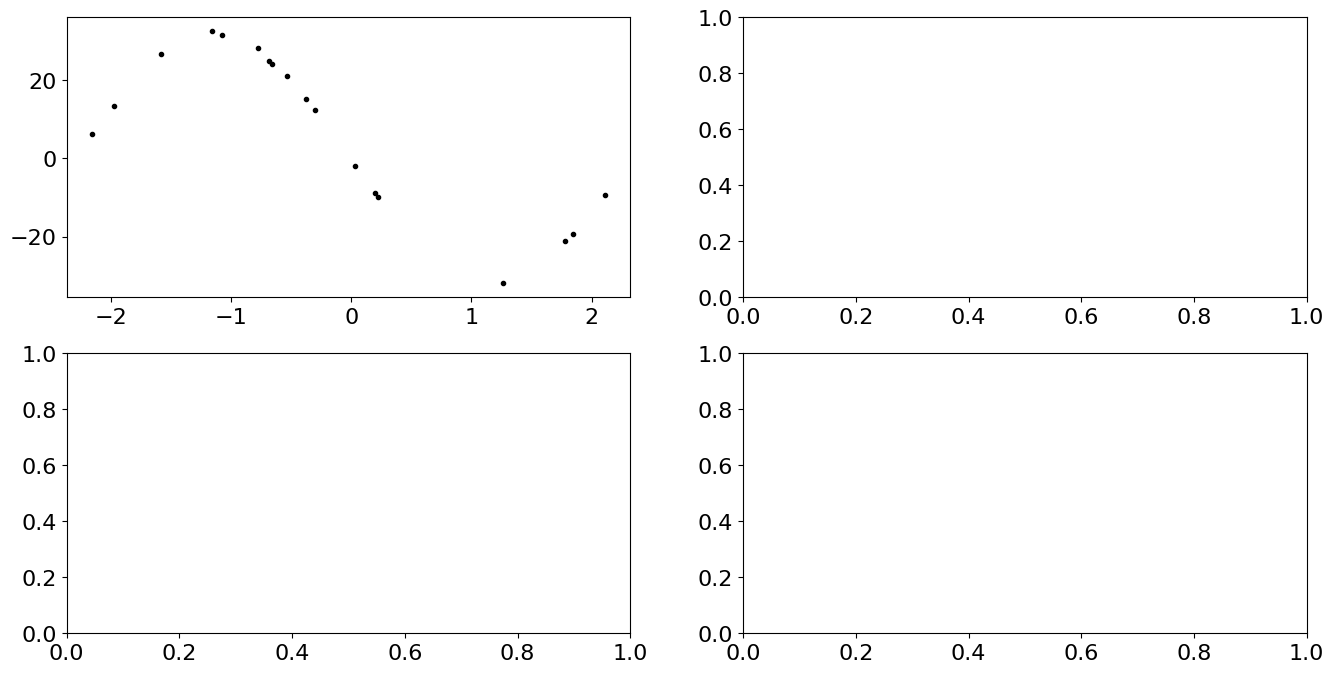

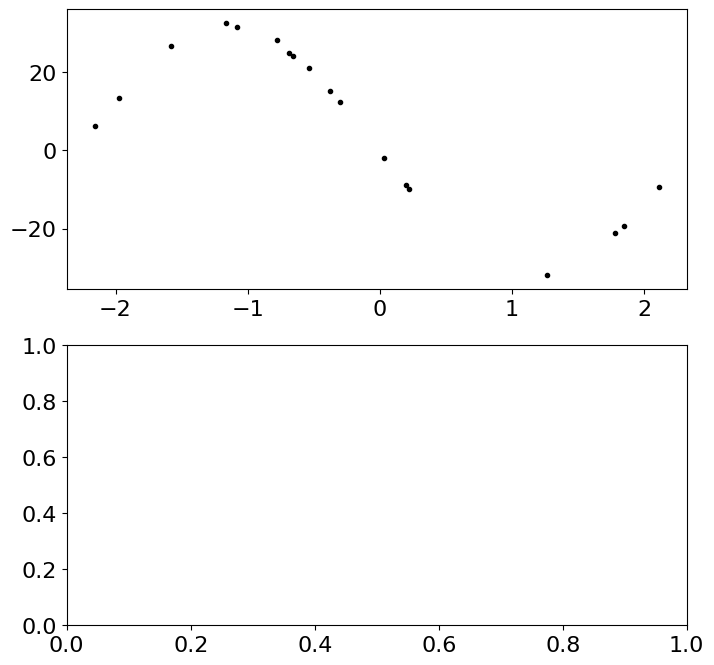

In [48]:
xo.utils.docs_setup()


# phase = np.linspace(0,1.,500)
# per = trace.posterior['period'].values
# t0 = trace.posterior['t0'].values
# x_phase = np.linspace(-0.5*np.median(per), 0.5*np.median(per), 100)

# mu_rv = trace.posterior['mean_rv'].values

flat_samps = indres['trace'].posterior.stack(sample=('chain', 'draw')) #trace.posterior.stack(sample=("chain", "draw"))

flat_samps = trace.posterior.stack(sample=("chain", "draw"))

# bkg = trace.posterior["mean_rv"].values
# rvphase = trace.posterior["rvphase"].values
# mcmc_per = trace.posterior['period'].values
p_med = flat_samps['period'].median().values
t0_med = flat_samps['t0'].median().values
mean_rv = flat_samps['mean_rv'].median().values
mean_lc = flat_samps['mean_lc'].median().values
# gp_pred = flat_samps['gp_pred'].median().values

fig, axes = plt.subplots(figsize=(16,8), ncols=2, nrows=2)
print(flat_samps['ecc'].median())

axes[0,0].errorbar(fold(x_rv, p_med, t0_med),
              y_rv, yerr=yerr_rv, fmt=".k")
rvvals = indres['rvvals']
lcvals = indres['lcvals']
fig, axes = plt.subplots(figsize=(8, 8), ncols=1, nrows=2)
print(flat_samps['ecc'].median())

axes[0].errorbar(fold(x_rv, p_med, t0_med),
              y_rv, yerr=yerr_rv, fmt=".k")

    
t_fold = fold(trv, p_med, t0_med)
inds = np.argsort(t_fold)
pred = np.percentile(rvvals, [16, 50, 84], axis=0)
axes[0,0].plot(t_fold[inds], pred[1][inds], color='C1', zorder=2)

pred = np.percentile(rvvals, [16, 84], axis=0)
art = axes[0,0].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color='C1', alpha=0.5, zorder=1)
art.set_edgecolor("none")

pred = np.percentile(rvvals, [5, 95], axis=0)
art = axes[0,0].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color='C1', alpha=0.25, zorder=0)
axes[0].plot(t_fold[inds], pred[1][inds], color='C1', zorder=2)

pred = np.percentile(rvvals, [16, 84], axis=0)
art = axes[0].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color='C1', alpha=0.5, zorder=1)
art.set_edgecolor("none")

pred = np.percentile(rvvals, [5, 95], axis=0)
art = axes[0].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color='C1', alpha=0.25, zorder=0)
art.set_edgecolor("none")

# pred = np.percentile(rvvals, [1, 99], axis=0)
# art = axes[0].fill_between(t_fold, pred[0], pred[1], color='C1', alpha=0.10, zorder=0)
# art.set_edgecolor("none")
# axes[0].set_ylim(-40, 40)
# axes[1].set_ylim(-40, 40)
axes[0,0].set_ylabel("RV [kms]")

x,y = extras['x'],extras['y']
# with model:
#     gp_pred = (
#         pmx.eval_in_model(extras["gp_lc_pred"], post_map_soln)
#     )

    
# axes[1,0].errorbar(fold(x, p_med, t0_med)
axes[0].set_xlabel('phase [days]')
axes[0].set_ylabel("RV [kms]")

x,y = extras['x'],extras['y']
with model:
    gp_pred = (
        pmx.eval_in_model(extras["gp_lc_pred"], map_soln)
    )
axes[1].errorbar(fold(x, p_med, t0_med),
              y-gp_pred, fmt=".k", ms=1, zorder=-1)

t_fold = fold(tlc, p_med, t0_med)
inds = np.argsort(t_fold)
pred = np.percentile(lcvals, [16, 50, 84], axis=0)
axes[1,0].plot(t_fold[inds], pred[1][inds], color='C1', zorder=2)

pred = np.percentile(lcvals, [16, 84], axis=0)
art = axes[1,0].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color='C1', alpha=0.5, zorder=1)
art.set_edgecolor("none")

pred = np.percentile(lcvals, [5, 95], axis=0)
art = axes[1,0].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color='C1', alpha=0.25, zorder=0)
axes[1].plot(t_fold[inds], pred[1][inds], color='C1', zorder=2)

pred = np.percentile(lcvals, [16, 84], axis=0)
art = axes[1].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color='C1', alpha=0.5, zorder=1)
art.set_edgecolor("none")

pred = np.percentile(lcvals, [5, 95], axis=0)
art = axes[1].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color='C1', alpha=0.25, zorder=0)
art.set_edgecolor("none")

# pred = np.percentile(flat_samps['lc_pred'][inds], [1, 99], axis=-1)
# art = axes[1].fill_between(t_fold[inds], pred[0], pred[1], color='C1', alpha=0.10, zorder=0)
# art.set_edgecolor("none")

axes[1,0].set_xlabel("phase [days]")
axes[1,0].set_ylabel("flux [ppt]")



#########################################################################################
file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/{TIC_TARGET}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_individual_priors_sampled_posterior_RV_LC.pickle", "rb")
phased_res = pk.load(file)
file.close()

p_med2 = phased_res['POSTmed']['p_med']
t0_med2 = phased_res['POSTmed']['t0_med']
trv2 = phased_res['trv']
rvvals2 = phased_res['rvvals']
lcvals2 = phased_res['lcvals']
gp_pred2 = phased_res['gp_pred']
trv2 = phased_res['trv']
tlc2 = phased_res['tlc']
axes[0,1].errorbar(fold(x_rv, p_med2, t0_med2),
              y_rv, yerr=yerr_rv, fmt=".k")

    
t_fold = fold(trv2, p_med2, t0_med2)
inds = np.argsort(t_fold)
pred = np.percentile(rvvals2, [16, 50, 84], axis=0)
axes[0,1].plot(t_fold[inds], pred[1][inds], color='C2', zorder=2)

pred = np.percentile(rvvals2, [16, 84], axis=0)
art = axes[0,1].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color='C2', alpha=0.5, zorder=1)
art.set_edgecolor("none")

pred = np.percentile(rvvals2, [5, 95], axis=0)
art = axes[0,1].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color='C2', alpha=0.25, zorder=0)
art.set_edgecolor("none")

# pred = np.percentile(rvvals, [1, 99], axis=0)
# art = axes[0].fill_between(t_fold, pred[0], pred[1], color='C1', alpha=0.10, zorder=0)
# art.set_edgecolor("none")
# axes[0].set_ylim(-40, 40)
# axes[1].set_ylim(-40, 40)
axes[1,1].set_xlabel("phase [days]")

# x,y = extras['x'],extras['y']

    
axes[1,1].errorbar(fold(phased_res['lcDAT'][0], p_med2, t0_med2),
              phased_res['lcDAT'][1]-gp_pred2, fmt=".k", ms=1, zorder=-1)

t_fold = fold(tlc2, p_med2, t0_med2)
inds = np.argsort(t_fold)
pred = np.percentile(lcvals2, [16, 50, 84], axis=0)
axes[1,1].plot(t_fold[inds], pred[1][inds], color='C2', zorder=2)

pred = np.percentile(lcvals2, [16, 84], axis=0)
art = axes[1,1].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color='C4', alpha=0.5, zorder=1)
art.set_edgecolor("none")

pred = np.percentile(lcvals2, [5, 95], axis=0)
art = axes[1,1].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color='C4', alpha=0.25, zorder=0)
art.set_edgecolor("none")

plt.subplots_adjust(hspace=0, wspace=0)
[subimg.tick_params(direction='in') for subimg in axes.flatten()]
axes[0,0].set_title("multivariate (4D)isochrones prior")
axes[0,1].set_title("individual priors")
plt.savefig(fig_dest + f"{TIC_TARGET.replace(' ','_').replace('-','_')}_{suffix}_rvphase_plot.png",dpi=150,bbox_inches='tight')
# plt.tight_layout()



ValueError: operands could not be broadcast together with shapes (10745,) (10731,) 

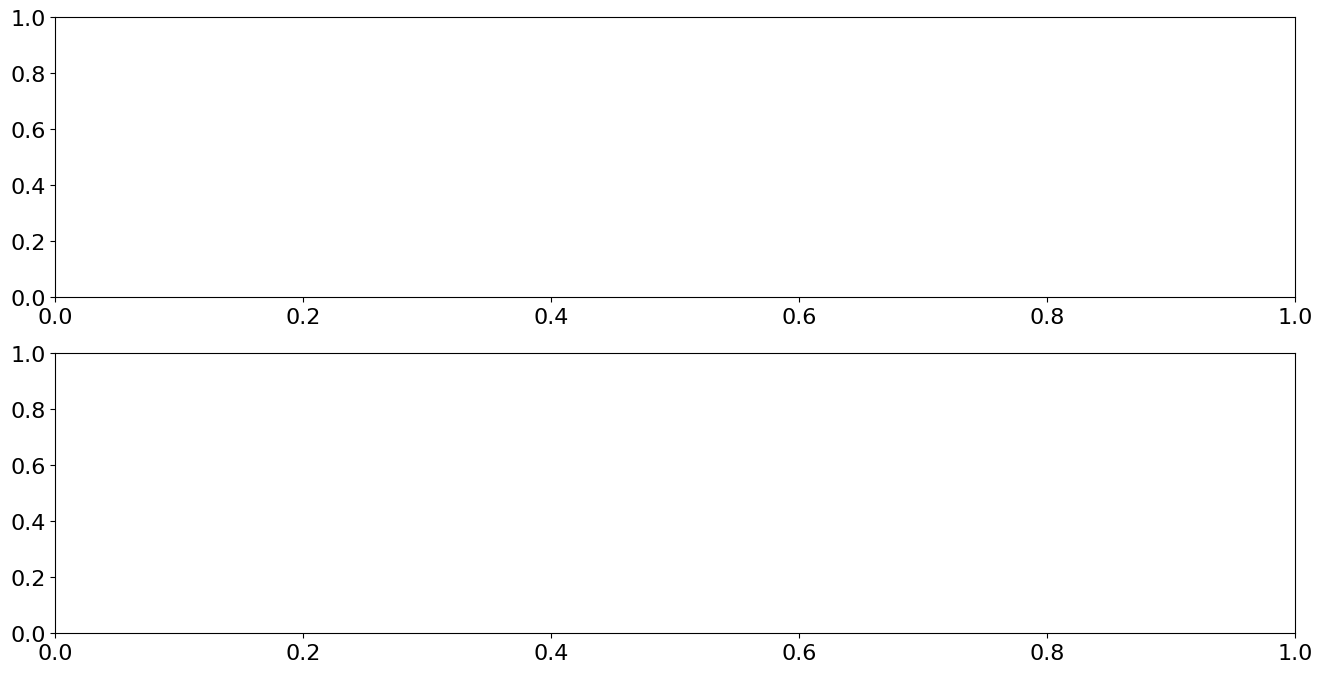

In [49]:
rvact = compute_value_in_post(model, trace, extras['model_rv'](x_rv), size=512)
lcact = compute_value_in_post(model, trace, extras['model_lc'](x), size=512)

fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(16,8))
xfold = fold(x, p_med, t0_med)
inds = np.argsort(xfold)

y_min_gp_pred = y-gp_pred
axes[0].plot(xfold[inds], y_min_gp_pred[inds] - np.percentile(lcact,50,axis=0)[inds], c='black',zorder=0,lw=0.5, label='multivariate priors')
y1,y2 = axes[0].set_ylim()
maxY = max(abs(y1),abs(y2))
axes[0].set_ylim(-maxY, maxY)
axes[0].axhline(0.0, ls='--', c='gray')

xfold = fold(x_rv, p_med, t0_med)
inds = np.argsort(xfold)
axes[1].plot(xfold[inds], y_rv[inds] - np.percentile(rvact, 50,axis=0)[inds], c='black',zorder=0,lw=1)
y1,y2 = axes[1].set_ylim()
maxY = max(abs(y1),abs(y2))
axes[1].set_ylim(-maxY, maxY)
axes[1].axhline(0.0, ls='--', c='gray')


y_min_gp_pred = phased_res['lcDAT'][1] - phased_res['gp_pred']
xfold = fold(phased_res['lcDAT'][0], phased_res["POSTmed"]['p_med'], phased_res['POSTmed']['t0_med'])
inds = np.argsort(xfold)
axes[0].plot(xfold[inds], y_min_gp_pred[inds] - np.percentile(phased_res['lcact'],50,axis=0)[inds],c='red',lw=0.5, label='individual priors')

xfold = fold(phased_res['rvDAT'][0], phased_res['POSTmed']['p_med'], phased_res['POSTmed']['t0_med'])
inds = np.argsort(xfold)
axes[1].plot(xfold[inds], phased_res['rvDAT'][1][inds] - np.percentile(phased_res['rvact'],50,axis=0)[inds], c='red',lw=1)


axes[0].set_ylabel("flux residuals [ppt]", fontsize=12)
axes[1].set_ylabel("RV residuals [kms]", fontsize=12)
axes[1].set_xlabel("phase [days]")
axes[0].set_title(TIC_TARGET)
axes[0].legend()
plt.savefig(fig_dest+f"{TIC_TARGET}_two_model_residuals_RV_LC.png",dpi=150,bbox_inches='tight')
axes[1].set_xlabel("phase [days]")
axes[1].set_ylabel("flux [ppt]")
plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/figs/{TIC_TARGET.replace(' ','_').replace('-','_')}_sampled_rvphase_plot.png",dpi=150,bbox_inches='tight')
# plt.tight_layout()

In [51]:
def plot_trace_values_from_individual_and_multivariate_models(TIC_TARGET, Ntune=1000, Ndraw=500, chains=4, suffix=suffix):
    
    file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/{TIC_TARGET}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_IND.pickle",'rb')
    ind_res_dict = pk.load(file)
    file.close()
    
    file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/{TIC_TARGET}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_{suffix}.pickle",'rb')
    mv_res_dict = pk.load(file)
    file.close()
    
#     parameters = individual_flat_samps.keys()
    multivariate_flat_samps = mv_res_dict['trace'].posterior.stack(sample=('chain','draw'))
    individual_flat_samps = ind_res_dict['trace'].posterior.stack(sample=("chain", "draw"))
    parameters = individual_flat_samps.keys()
    print(individual_flat_samps['a'])
#     fig,ax = plt.subplots(figsize=(10,10))
    fig = plt.figure(figsize=(15,15))
    gs = GridSpec(ncols=100,nrows=100)

    ax = fig.add_subplot(gs[:,:])
    subax = fig.add_subplot(gs[70:95,70:95])
    markers = ['o','^','s','+','P']
    cmind = plt.cm.tab20.colors
    for ii,col in enumerate(parameters):
        np.median(individual_flat_samps[col])
        if col in multivariate_flat_samps.keys():
            random_index1 = np.random.randint(low=0,high=5)
            random_index2 = np.random.randint(low=0,high=20)
            x = np.percentile(individual_flat_samps[col],[16,50,84])
            y = np.percentile(multivariate_flat_samps[col], [16,50,84])
            print(col,x,y)
            if col!='tn':
                ax.errorbar(x[1],y[1], xerr=[[x[0]],[x[2]]], yerr=[[y[0]],[y[2]]],
                            fmt=markers[random_index1],
                        mfc=cmind[random_index2],ecolor=cmind[random_index2],
                       label=col,markersize=10)
            if col=='tn':
                subax.errorbar(x[1],y[1], xerr=[[x[0]],[x[2]]], yerr=[[y[0]],[y[2]]],
                            fmt=markers[random_index1],
                        mfc=cmind[random_index2],ecolor=cmind[random_index2],
                       label=col,markersize=10)
#     plt.loglog(True)
    subax.legend(fontsize=10,ncol=3)
    ax.legend(fontsize=10,ncol=2)
    x1,x2 = ax.set_xlim()
    y1,y2 = ax.set_ylim()
#     ax.set_xlim(min(x1,y1),max(x2,y2))
#     ax.set_ylim(min(x1,y1),max(x2,y2))
    ax.set_ylim(-10,20)
    ax.set_xlim(-10,20)
    ax.plot([min(x1,y1),max(x2,y2)],[min(x1,y1),max(x2,y2)], ls='--', zorder=-1)
    
    x1,x2 = subax.set_xlim()
    y1,y2 = subax.set_ylim()
    subax.set_xlim(min(x1,y1),max(x2,y2))
    subax.set_ylim(min(x1,y1),max(x2,y2))
    subax.plot([min(x1,y1),max(x2,y2)],[min(x1,y1),max(x2,y2)], ls='--', zorder=-1)
    
    ax.set_xlabel("individual priors")
    ax.set_ylabel("multivariate prior on log(M1,R1,q,s)")
    ax.set_title(TIC_TARGET)

In [53]:
def plot_both_posterior_contours(TIC_TARGET, Ntune=1000, Ndraw=500, chains=4):
    
    file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/{TIC_TARGET}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_IND.pickle",'rb')
    ind_res_dict = pk.load(file)
    file.close()
    
    file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/{TIC_TARGET}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_{suffix}.pickle",'rb')
    mv_res_dict = pk.load(file)
    file.close()
                                 
    MVtrace = mv_res_dict['trace']
    MVmapsoln = mv_res_dict['map_soln']
    INDtrace = ind_res_dict['trace']
    
    from corner import corner
    fig = corner(MVtrace, var_names=['M1','R1','q','s','k','b','period','log_sigma_rv','t0','tn','ecc', 'omega'], smooth=1, use_math_text=True,
          truths=[MVmapsoln['M1'], MVmapsoln['R1'], MVmapsoln['q'], MVmapsoln['s'], MVmapsoln['k'], MVmapsoln['b'], 
                  MVmapsoln['period'], MVmapsoln['log_sigma_rv'], 
                  MVmapsoln['t0'], MVmapsoln['tn'], MVmapsoln['ecc'], MVmapsoln['omega']],
            truth_color='gray', range=[1,1,1,1,1,1,1,1,1,1,1,1])
    
    corner(INDtrace, var_names=['M1','R1','q','s','k','b','period','log_sigma_rv','t0','tn','ecc', 'omega'], 
           smooth=1, use_math_text=True, fig=fig, color='red',range=[1,1,1,1,1,1,1,1,1,1,1,1])

    fig.axes[0].set_title("red:INDprior\nblk:MVprior")

In [54]:
plot_both_posterior_contours(TIC_TARGET)
plt.savefig(fig_dest + f"{TIC_TARGET.replace(' ','_')}_corner_plot_of_individual_priors_and_diagonal_MV_priors.png",dpi=150,bbox_inches='tight')

In [148]:
fig,axes = plt.subplots(figsize=(10,10))

scatr_cols = ['red','black','blue','cyan']
mrkr_type = ['+','o','^','s']
for ii,model_type in enumerate(['diagonal_MV_prior', 'isotropized_isochrones_MV_prior', 'isochrones_MV_prior', 'diagonalized_isochrones_MV_prior']):
    file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/{'TIC 272074664'}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{6}_{model_type}.pickle",'rb')
    indres = pk.load(file)
    file.close()

    imap_soln = indres['map_soln']
    ipost_map_soln = indres['trace'].posterior.stack(sample=("chain","draw"))
    plot_map = np.array([])
    plot_postmap =np.array([])
    for cols in imap_soln.keys():
        if (cols in imap_soln.keys()) & (cols in ipost_map_soln.keys()):
            plot_map = np.append(plot_map, imap_soln[cols])
            plot_postmap = np.append(plot_postmap, np.median(ipost_map_soln[cols],axis=-1))

    axes.scatter(plot_map[plot_map <100], plot_postmap[plot_map < 100], label=model_type, ec=scatr_cols[ii], marker=mrkr_type[ii], fc='None',s=100)
    
x1,x2 = axes.set_xlim()
y1,y2 = axes.set_ylim()
axes.set_xlim(min(x1,y1),max(x2,y2))
axes.set_ylim(min(x1,y1),max(x2,y2))
axes.legend()
axes.plot([-1000,1000],[-1000,1000],ls='--',zorder=-1)
axes.set_xlabel("MAP SOLN")
axes.set_ylabel("MED(POSTERIORS)")
plt.savefig(fig_dest+f'{TIC_TARGET}_one_to_one_plot_of_posterior_medians_and_final_map_solns.png',dpi=150, bbox_inches='tight')
# axes.loglog(True)

In [7]:
def plot_residuals_of_models(TIC_TARGET=None,Ntune=1000, Ndraw=500, chains=4,
                                model_list=('diagonal','isotropized_isochrones','isochrones', 'diagonalized_isochrones')):

    fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(16,8))    
    
    for ii,model_type in enumerate(model_list):
        file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/{TIC_TARGET}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_{model_type}_MV_prior.pickle",'rb')
        indres = pk.load(file)
        file.close()
#         print(model_type)
#         pymc3dict = load_all_data_for_pymc3_model(TIC_TARGET,sparse_factor=5)
#         print(indres.keys())
        x,y = indres['lcdat']['x'],indres['lcdat']['y']
        x_rv, y_rv = indres['rvdat']['x_rv'],indres['rvdat']['y_rv']
              
        lcact = indres['lcact']
        rvact = indres['rvact']
        
#         with model:
#             gp_pred = (
#                 pmx.eval_in_model(extras['gp_lc_pred'], indres['map_soln'])
#                       )
            
        flat_samps = indres['trace'].posterior.stack(sample=("chain","draw"))
        p_med = np.median(flat_samps['period'])
        t0_med = np.median(flat_samps['t0'])
        
        xfold = fold(x, p_med, t0_med)
        inds = np.argsort(xfold)
#         print(len(indres['mask']),len(y))
        y_min_gp_pred = y - indres['gp_pred']
        axes[0].plot(xfold[inds], y_min_gp_pred[inds] - np.median(lcact,axis=0)[indres['mask']][inds], c=f"C{ii*3}",zorder=ii,lw=0.5, label=model_type)


        y1,y2 = axes[0].set_ylim()
        maxY = max(abs(y1),abs(y2))
#         axes[0].set_ylim(-maxY, maxY)
        axes[0].axhline(0.0, ls='--', c='gray')

        xfold = fold(x_rv, p_med, t0_med)
        inds = np.argsort(xfold)
        axes[1].plot(xfold[inds], y_rv[inds] - np.median(rvact,axis=0)[inds], c=f"C{ii*3}",zorder=ii,lw=3, label=model_type)
        y1,y2 = axes[1].set_ylim()
        maxY = max(abs(y1),abs(y2))
#         axes[1].set_ylim(-maxY, maxY)
        axes[1].axhline(0.0, ls='--', c='gray')
        

#         y_min_gp_pred = phased_res['lcDAT'][1] - phased_res['gp_pred']
#         xfold = fold(phased_res['lcDAT'][0], phased_res["POSTmed"]['p_med'], phased_res['POSTmed']['t0_med'])
#         inds = np.argsort(xfold)
#         axes[0].plot(xfold[inds], y_min_gp_pred[inds] - np.percentile(phased_res['lcact'],50,axis=0)[inds],c='red',lw=0.5, label='individual priors')

#         xfold = fold(phased_res['rvDAT'][0], phased_res['POSTmed']['p_med'], phased_res['POSTmed']['t0_med'])
#         inds = np.argsort(xfold)
#         axes[1].plot(xfold[inds], phased_res['rvDAT'][1][inds] - np.percentile(phased_res['rvact'],50,axis=0)[inds], c='red',lw=1)

        axes[0].set_ylim(min(y), max(y))
        axes[1].set_ylim(min(y_rv), max(y_rv))
        
        axes[0].set_ylabel("flux residuals [ppt]", fontsize=12)
        axes[1].set_ylabel("RV residuals [kms]", fontsize=12)
        axes[1].set_xlabel("phase [days]")
        axes[0].set_title(TIC_TARGET)
        axes[1].legend(fontsize=10, loc='best')

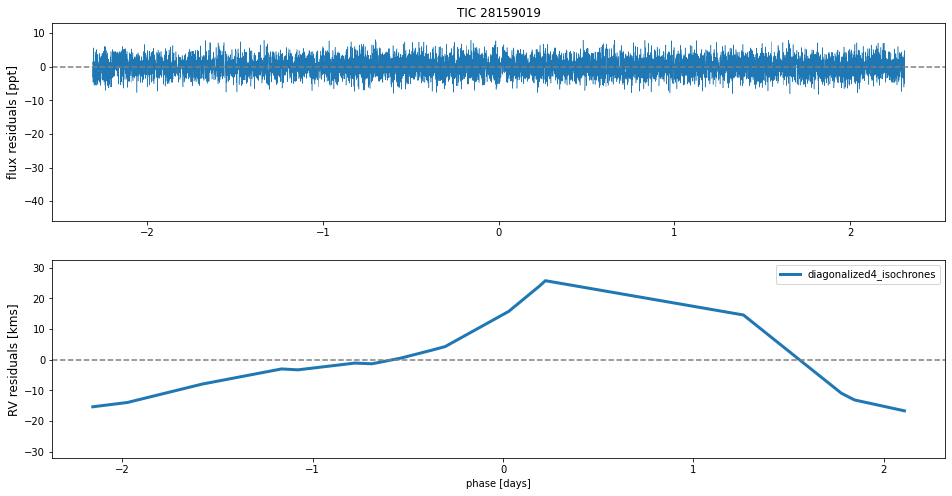

In [55]:
from helper_functions import *
plot_target = 'TIC 28159019'
plot_residuals_of_models(plot_target,chains=8, model_list=['diagonalized4_isochrones'],Ntune=1000, Ndraw=500)#, model_list=('diagonalized_isochrones', 'diagonalized4_isochrones'), chains=6)
plot_dest = f'/Users/kjaehnig/CCA_work/GAT/apotess_systems/{plot_target.replace(" ","_")}_files/figures/'
plt.savefig(plot_dest+f"{plot_target}_four_model_LC_RV_residuals.png",dpi=150, bbox_inches='tight')

In [527]:
def plot_all_model_corners(TIC_TARGET, Ntune=1000, Ndraw=500, chains=4,
                                model_list=['diagonal','isotropized_isochrones','isochrones', 'diagonalized_isochrones']):
    
    for ii, model_type in enumerate(model_list):
    
#     file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/{TIC_TARGET}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_IND.pickle",'rb')
#     ind_res_dict = pk.load(file)
#     file.close()
        try:
            xslabels = [r'$log{\rho}$', r'$logM_{1}$', r'$logR_{1}$', r'$logQ$', r'$logS$', r'$logK$','b',r'$t_{0}$', r'$t_{n}$']
            file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/{TIC_TARGET}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_individual_priors_{model_type}_isochrones.pickle",'rb')
            mv_res_dict = pk.load(file)
            file.close()

            MVtrace = mv_res_dict['trace']
            MVtrace.posterior['log_rho'] = np.log( MVtrace.posterior['M1'] / ( (4./3.) * np.pi * MVtrace.posterior['R1']**3.) )

            MVmapsoln = mv_res_dict['map_soln']
            MVmapsoln['log_rho'] = np.log( MVmapsoln['M1'] / ( (4./3.) * np.pi * MVmapsoln['R1']**3.) )
    #         INDtrace = ind_res_dict['trace']
            print(ii)
            if ii == 0:
                fig = corner(MVtrace, var_names=['log_rho','log_M1','log_R1','log_q','log_s','log_k','b','t0','tn'], smooth=1, use_math_text=True,
                  truths=MVmapsoln, labels=xslabels, labelpad=0.1, label_kwargs={'fontsize':16},
                    truth_color='gray', range=[1,1,1,1,1,1,1,1,1], color=f'C{ii*3}',label=model_type)

            if ii > 0:
                corner(MVtrace, var_names=['log_rho','log_M1','log_R1','log_q','log_s','log_k','b','t0','tn'], 
                   smooth=1, use_math_text=True, fig=fig, color=f'C{ii*3}',range=[1,1,1,1,1,1,1,1,1,], label=model_type,
                      labels=xslabels, labelpad=0.1, truths=MVmapsoln)
            fig.text(0.50,(75-ii*2.)/100.,model_type, color=f'C{ii*3}',fontsize=30)
        except:
            continue

# #     fig.text(0.50,0.74,'isotropized isochrones', color='C3', size=16)
# #     fig.text(0.5,0.73, 'isochrones', color='C6', size=16)
# #     fig.text(0.5,0.72, 'diagonalized isochrones', color='C9', size=16)
# #     fig.axes[0].set_title()
# flat_samps = trace.posterior.stack(sample=("chain", "draw"))
# # for data_var in flat_samps.data_vars.keys():
# #     print(data_var)
# plt.figure()



# # Get the posterior median orbital parameters
# p = np.median(flat_samps["period"])
# t0 = np.median(flat_samps["t0"])
# lcpred = np.percentile(flat_samps['lc_pred'], 50,axis=0)
# mod_phase = np.linspace(-.3, 0.3, len(lcpred))

# # Plot the folded data
# x_fold = (x[mask] - t0 + 0.5 * p) % p - 0.5 * p
# m = np.abs(x_fold) < 0.3
# plt.plot(
#     x_fold[m], y[mask][m] - np.std(lcpred), ".k", label="data", zorder=-1000
# )



# plt.plot(mod_phase, lcpred)

0
1
2
3


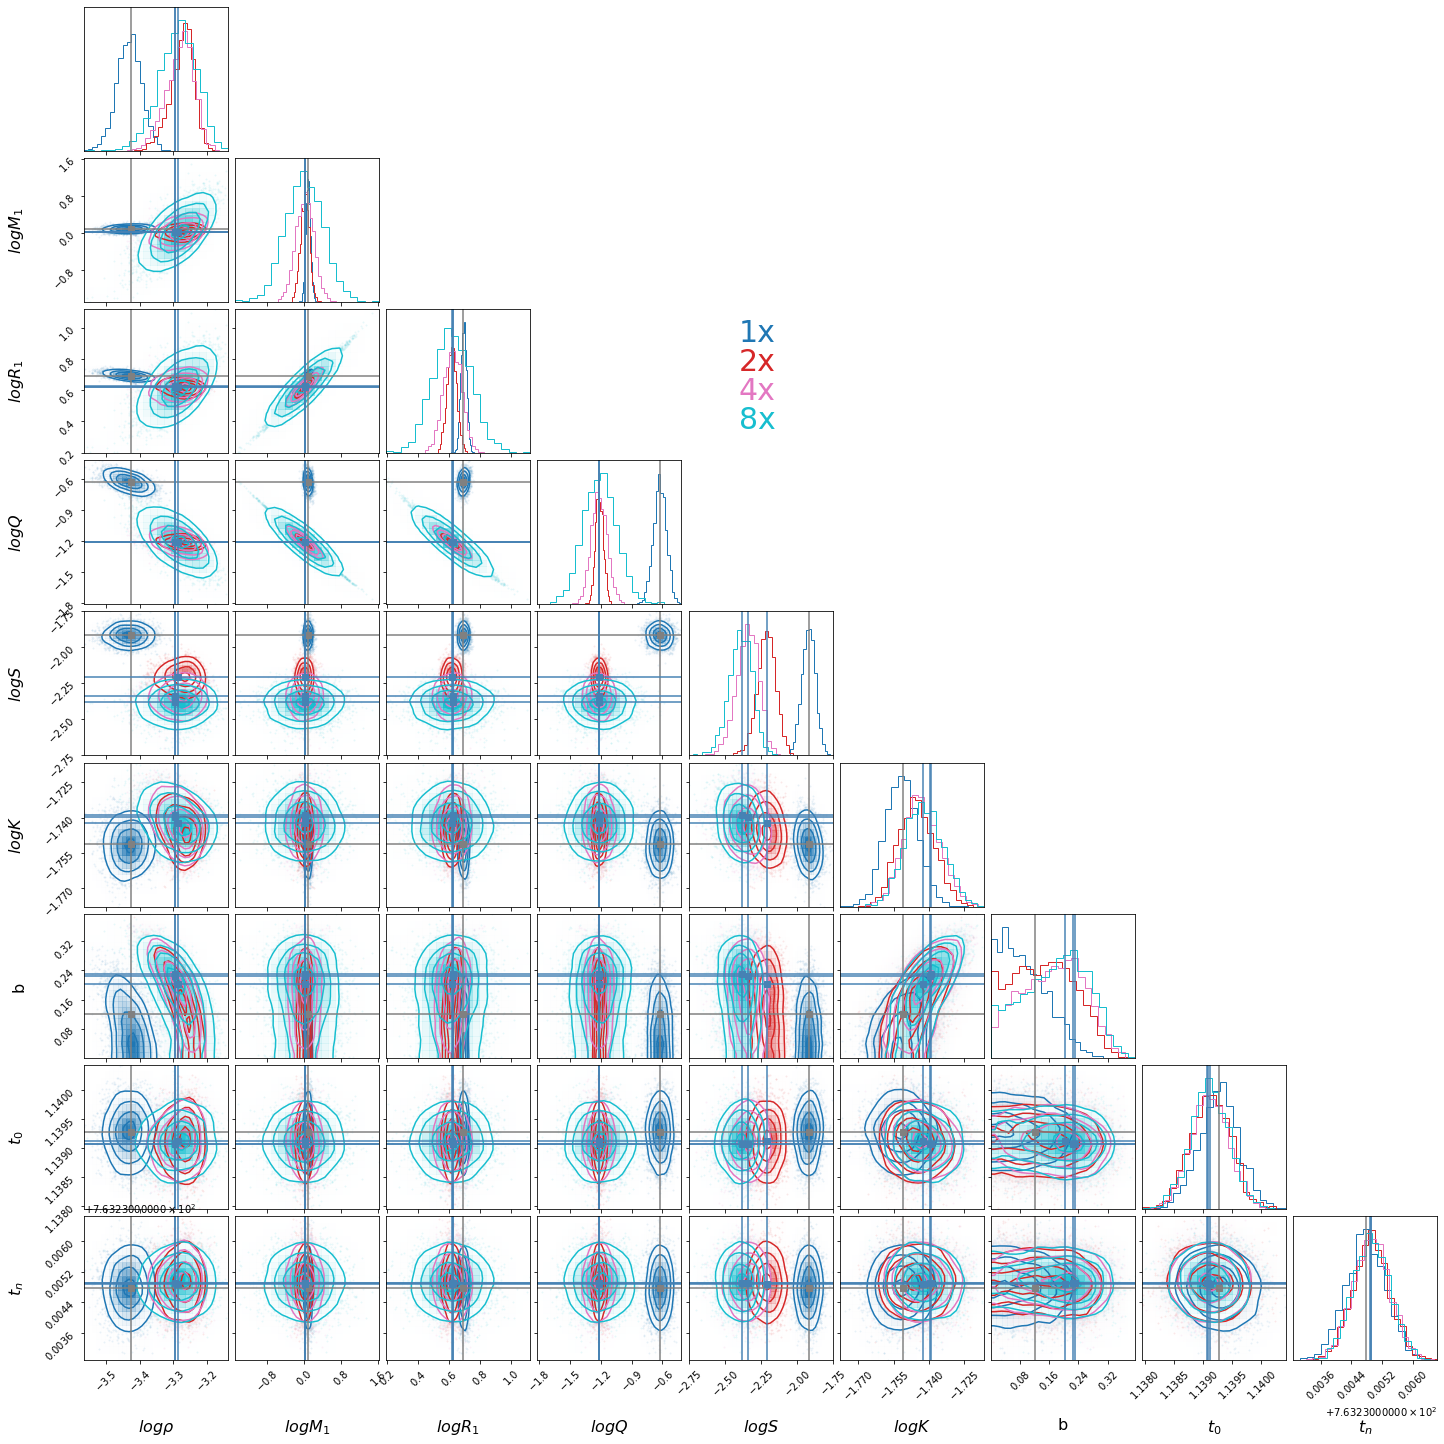

In [528]:
from helper_functions import *
plot_target = 'TIC 28159019'
plot_all_model_corners(plot_target, chains=6, Ntune=1000, Ndraw=500, model_list=['1x','2x','4x','8x'])
plot_dest = f'/Users/kjaehnig/CCA_work/GAT/apotess_systems/{plot_target.replace(" ","_")}_files/figures/'
# plt.savefig(plot_dest+f"{plot_target}_four_MV_model_corner_plot.png", dpi=150, bbox_inches='tight')
plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/apotess_systems/{plot_target.replace(' ','_')}_files/{plot_target.replace(' ','_')}_multi_model_post_corner.png",
            bbo_inches='tight', dpi=150)

In [525]:
def plot_LC_RV_phased_curves(TIC_TARGET, Ntune=1000, Ndraw=500, chains=4,
                                model_list=['diagonal','isotropized_isochrones','isochrones', 'diagonalized_isochrones'],
                            save_to_disk=False):
    
    
    fig, axes = plt.subplots(figsize=(10,10), ncols=1, nrows=2)

    for ii, model_type in enumerate(model_list):
        try:
            modcol = f"C{int((ii*3)+1)}"

            file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/{TIC_TARGET}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_individual_priors_{model_type}_isochrones.pickle",'rb')
            mv_res_dict = pk.load(file)
            file.close()

            flat_samps = mv_res_dict['trace'].posterior.stack(sample=('chain','draw'))
            x_rv = mv_res_dict['rvdat']['x_rv']
            y_rv = mv_res_dict['rvdat']['y_rv']
            yerr_rv = mv_res_dict['rvdat']['yerr_rv']

            x = mv_res_dict['lcdat']['x']
            y = mv_res_dict['lcdat']['y']
            yerr = mv_res_dict['lcdat']['yerr']

            gp_pred = mv_res_dict['gp_pred']

            trv = mv_res_dict['trv']
            tlc = mv_res_dict['tlc'] 

            rvvals = mv_res_dict['rvvals']
            lcvals = mv_res_dict['lcvals']

            p_med = flat_samps['period'].median().values
            t0_med = flat_samps['t0'].median().values
            mean_rv = flat_samps['mean_rv'].median().values
            mean_lc = flat_samps['mean_lc'].median().values
            # gp_pred = flat_samps['gp_pred'].median().values

            # print(flat_samps['ecc'].median())
            if ii == 0:
                axes[0].errorbar(fold(x_rv, p_med, t0_med),
                          y_rv, yerr=yerr_rv, fmt=".k")
            # rvvals = indres['rvvals']
            # lcvals = indres['lcvals']

            t_fold = fold(trv, p_med, t0_med)
            inds = np.argsort(t_fold)
            pred = np.percentile(rvvals, [16, 50, 84], axis=0)
            axes[0].plot(t_fold[inds], pred[1][inds], color=modcol, zorder=2)

            pred = np.percentile(rvvals, [16, 84], axis=0)
            art = axes[0].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color=modcol, alpha=0.5, zorder=1)
            art.set_edgecolor("none")

            pred = np.percentile(rvvals, [5, 95], axis=0)
            art = axes[0].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color=modcol, alpha=0.25, zorder=0)
            art.set_edgecolor("none")

            # pred = np.percentile(rvvals, [1, 99], axis=0)
            # art = axes[0].fill_between(t_fold, pred[0], pred[1], color='C1', alpha=0.10, zorder=0)
            # art.set_edgecolor("none")
            # axes[0].set_ylim(-40, 40)
            # axes[1].set_ylim(-40, 40)
            axes[0].set_ylabel("RV [kms]")

    #         x,y = extras['x'],extras['y']
            # with model:
            #     gp_pred = (
            #         pmx.eval_in_model(extras["gp_lc_pred"], post_map_soln)
            #     )

            if ii == 0:
                axes[1].errorbar(fold(x, p_med, t0_med),
                          y-gp_pred, fmt=".k", ms=1, zorder=-1)

            t_fold = fold(tlc, p_med, t0_med)
            inds = np.argsort(t_fold)
            pred = np.percentile(lcvals, [16, 50, 84], axis=0)
            axes[1].plot(t_fold[inds], pred[1][inds], color=modcol, zorder=2,label=model_type)

            pred = np.percentile(lcvals, [16, 84], axis=0)
            art = axes[1].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color=modcol, alpha=0.5, zorder=1)
            art.set_edgecolor("none")

            pred = np.percentile(lcvals, [5, 95], axis=0)
            art = axes[1].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color=modcol, alpha=0.25, zorder=0)
            art.set_edgecolor("none")

            # pred = np.percentile(flat_samps['lc_pred'][inds], [1, 99], axis=-1)
            # art = axes[1].fill_between(t_fold[inds], pred[0], pred[1], color='C1', alpha=0.10, zorder=0)
            # art.set_edgecolor("none")
            axes[1].legend()
            axes[1].set_xlabel("phase [days]")
            axes[1].set_ylabel("flux [ppt]")
            axes[0].set_title(TIC_TARGET)
        except:
            continue
    if save_to_disk:
        plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/apotess_systems/{TIC_TARGET.replace(' ','_')}_files/multi_model_RV_LC_curves.png", bbox_inches='tight', dpi=150)
        

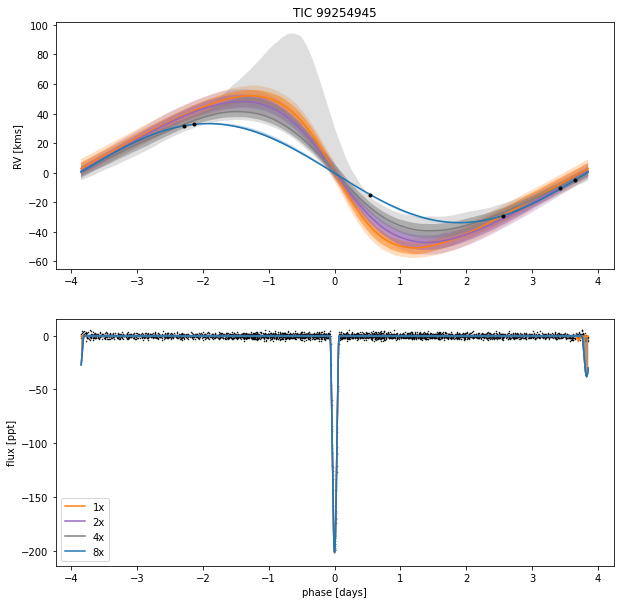

In [530]:
plot_target = 'TIC 99254945'
plot_LC_RV_phased_curves(plot_target, chains=6, Ntune=1000, Ndraw=500, model_list=['1x','2x','4x','8x'], save_to_disk=True)

In [485]:
def plot_LC_RV_phased_curve_gallery(TIC_TARGETs=['TIC 20215452'], Ntune=1000, Ndraw=500, chains=4,
                                model_list=['1x'], save_to_disk=False):
    
    
    fig, all_axes = plt.subplots(figsize=(20,12), ncols=len(TIC_TARGETs), nrows=2)

    for jj, ticid in enumerate(TIC_TARGETs):
        if len(TIC_TARGETs)==1:
            axes = all_axes
        else:
            axes = all_axes[:,jj]
        #         print(axes)
        for ii, model_type in enumerate(model_list):

            modcol = f"C{int((ii*3)+1)}"
            try:
                file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/{ticid}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_individual_priors_{model_type}_isochrones.pickle",'rb')
                mv_res_dict = pk.load(file)
                file.close()

                flat_samps = mv_res_dict['trace'].posterior.stack(sample=('chain','draw'))
                x_rv = mv_res_dict['rvdat']['x_rv']
                y_rv = mv_res_dict['rvdat']['y_rv']
                yerr_rv = mv_res_dict['rvdat']['yerr_rv']

                x = mv_res_dict['lcdat']['x']
                y = mv_res_dict['lcdat']['y']
                yerr = mv_res_dict['lcdat']['yerr']

                gp_pred = mv_res_dict['gp_pred']

                trv = mv_res_dict['trv']
                tlc = mv_res_dict['tlc'] 

                rvvals = mv_res_dict['rvvals']
                lcvals = mv_res_dict['lcvals']

                p_med = flat_samps['period'].median().values
                t0_med = flat_samps['t0'].median().values
                mean_rv = flat_samps['mean_rv'].median().values
                mean_lc = flat_samps['mean_lc'].median().values
                # gp_pred = flat_samps['gp_pred'].median().values

                # print(flat_samps['ecc'].median())

                axes[0].errorbar(fold(x_rv, p_med, t0_med),
                              y_rv, yerr=yerr_rv, fmt=".k")
                # rvvals = indres['rvvals']
                # lcvals = indres['lcvals']

                t_fold = fold(trv, p_med, t0_med)
                inds = np.argsort(t_fold)
                pred = np.percentile(rvvals, [16, 50, 84], axis=0)
                axes[0].plot(t_fold[inds], pred[1][inds], color=modcol, zorder=2)

                pred = np.percentile(rvvals, [16, 84], axis=0)
                art = axes[0].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color=modcol, alpha=0.5, zorder=1)
                art.set_edgecolor("none")

                pred = np.percentile(rvvals, [5, 95], axis=0)
                art = axes[0].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color=modcol, alpha=0.25, zorder=0)
                art.set_edgecolor("none")

                # pred = np.percentile(rvvals, [1, 99], axis=0)
                # art = axes[0].fill_between(t_fold, pred[0], pred[1], color='C1', alpha=0.10, zorder=0)
                # art.set_edgecolor("none")
                # axes[0].set_ylim(-40, 40)
                # axes[1].set_ylim(-40, 40)
                axes[0].set_ylabel("RV [kms]")

        #         x,y = extras['x'],extras['y']
                # with model:
                #     gp_pred = (
                #         pmx.eval_in_model(extras["gp_lc_pred"], post_map_soln)
                #     )


                axes[1].errorbar(fold(x, p_med, t0_med),
                              y-gp_pred, fmt=".k", ms=1, zorder=-1)

                t_fold = fold(tlc, p_med, t0_med)
                inds = np.argsort(t_fold)
                pred = np.percentile(lcvals, [16, 50, 84], axis=0)
                axes[1].plot(t_fold[inds], pred[1][inds], color=modcol, zorder=2,label=model_type)

                pred = np.percentile(lcvals, [16, 84], axis=0)
                art = axes[1].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color=modcol, alpha=0.5, zorder=1)
                art.set_edgecolor("none")

                pred = np.percentile(lcvals, [5, 95], axis=0)
                art = axes[1].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color=modcol, alpha=0.25, zorder=0)
                art.set_edgecolor("none")

                # pred = np.percentile(flat_samps['lc_pred'][inds], [1, 99], axis=-1)
                # art = axes[1].fill_between(t_fold[inds], pred[0], pred[1], color='C1', alpha=0.10, zorder=0)
                # art.set_edgecolor("none")
                axes[1].legend(fontsize=12)
                axes[0].set_title(f"{ticid}")
                axes[1].set_xlabel("phase [days]")
                axes[1].set_ylabel("flux [ppt]")
            except:
                continue
    if save_to_disk:
        plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/{'_'.join(TIC_TARGETs).replace(' ','_')}_LC_curves.png", bbox_inches='tight', dpi=150)
        

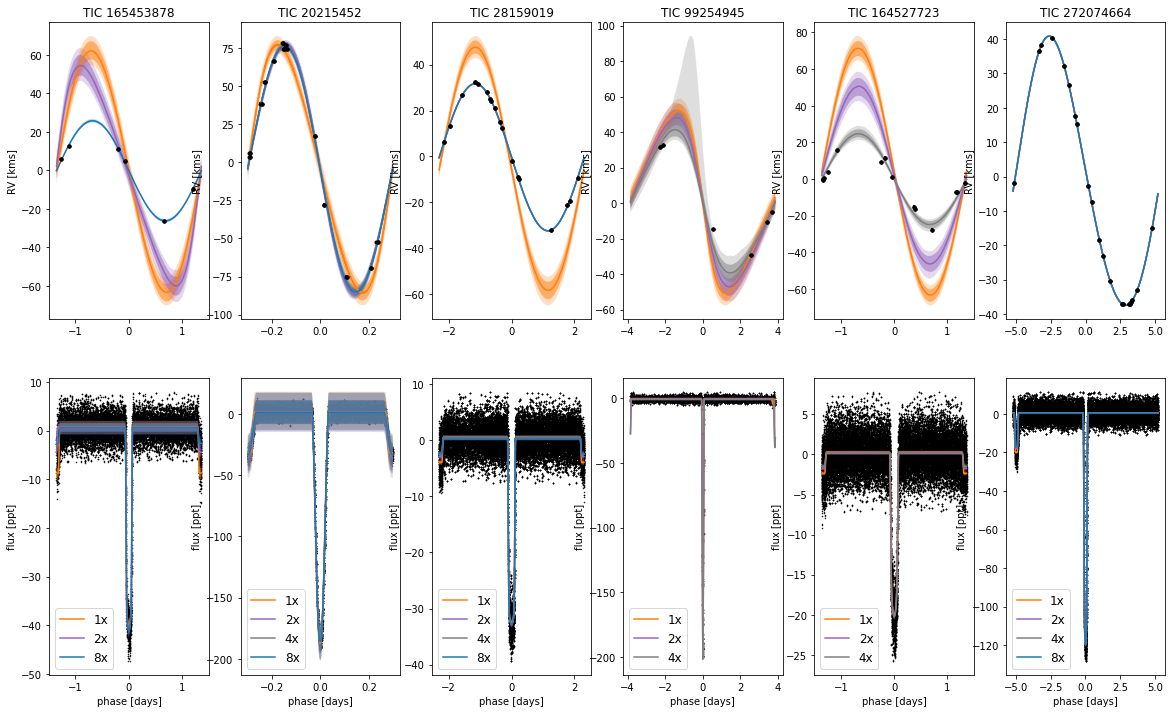

In [491]:
plot_targets = [f'TIC {id}' for id in ['165453878','20215452','28159019','99254945','164527723','272074664']]#,'99254945','164527723','258108067']]
# plot_targets = [f'TIC {id}' for id in ['20215452','164458426','165453878','258108067','271548206']]
plot_LC_RV_phased_curve_gallery(plot_targets, chains=6, Ntune=1000, Ndraw=500, model_list=['1x','2x','4x','8x'],save_to_disk=True)

In [463]:
def plot_3panel_LC_plot_gallery(TIC_TARGETs=['TIC 20215452'], Ntune=1000, Ndraw=500, chains=4,
                                model_list=['1x'], save_to_disk=False):
    
    
    fig, all_axes = plt.subplots(figsize=(20,16), ncols=len(TIC_TARGETs), nrows=3, sharex=True)

    for jj, ticid in enumerate(TIC_TARGETs):
        if len(TIC_TARGETs)==1:
            axes = all_axes
        else:
            axes = all_axes[:,jj]
        
#         print(axes)
        for ii, model_type in enumerate(model_list):

            modcol = 'red'#f"C{int((ii*0)+1)}"
            
            file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/{ticid}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_individual_priors_{model_type}_isochrones.pickle",'rb')
            mv_res_dict = pk.load(file)
            file.close()

            flat_samps = mv_res_dict['trace'].posterior.stack(sample=('chain','draw'))
            x_rv = mv_res_dict['rvdat']['x_rv']
            y_rv = mv_res_dict['rvdat']['y_rv']
            yerr_rv = mv_res_dict['rvdat']['yerr_rv']

            x = mv_res_dict['lcdat']['x']
            y = mv_res_dict['lcdat']['y']
            yerr = mv_res_dict['lcdat']['yerr']

            gp_pred = mv_res_dict['gp_pred']

            trv = mv_res_dict['trv']
            tlc = mv_res_dict['tlc'] 

            rvvals = mv_res_dict['rvvals']
            lcvals = mv_res_dict['lcvals']

            p_med = flat_samps['period'].median().values
            t0_med = flat_samps['t0'].median().values
            mean_rv = flat_samps['mean_rv'].median().values
            mean_lc = flat_samps['mean_lc'].median().values

            print(p_med)
            hp = 0.5 * p_med


            ### first subplot - the unfolded time series with model
            #### (tn - t0) / Ntrans = PERIOD; tn = (period*Ntrans) + t0
#             tn_med = (p_med * 0) + t0_med
            
            axes[0].errorbar((x - t0_med), y, yerr=yerr, fmt=".k",ecolor='gray')
            axes[0].set_xlim(-hp, +hp) 
            
            xlim1 = axes[0].set_xlim()
            ylim1 = axes[0].set_ylim()
            
            axes[0].text(0.95 * xlim1[1], 0.95*ylim1[1],
                         "unfolded lightcurve",
                         horizontalalignment='right',
                         verticalalignment='top', fontsize=16)
            # rvvals = indres['rvvals']
            # lcvals = indres['lcvals']

#             t_fold = fold(x, p_med, t0_med)

            t_fold = (x - t0_med + hp) % p_med - hp
            inds = np.argsort(t_fold)
            axes[1].errorbar(t_fold,
                          y, fmt=".k", ms=1, yerr=yerr, zorder=-1, ecolor='gray')
            axes[1].plot(t_fold[inds], gp_pred[inds], ls='--', color='gold')
#             axes[1].set_xlim(-t0_med, t0_med)
#             axes[1].set_xlim(-t0_med, t0_med) 

            t_fold = (tlc - t0_med + hp) % p_med - hp
#             t_fold = fold(tlc, p_med, t0_med)
            inds = np.argsort(t_fold)
            pred = np.percentile(lcvals, [16, 50, 84], axis=0)
            axes[1].plot(t_fold[inds], pred[1][inds], color=modcol, zorder=2,lw=2)

            axes[1].text(0.95 * xlim1[1], 0.95*ylim1[1],
                         "folded lightcurve, no GP subtraction",
                         horizontalalignment='right',
                         verticalalignment='top', fontsize=16)
            
            
            t_fold = (x - t0_med + hp) % p_med - hp #fold(tlc, p_med, t0_med)
            inds = np.argsort(t_fold)
            axes[2].errorbar(t_fold[inds],
                          y[inds]-gp_pred[inds], fmt=".k", yerr=yerr, ms=1, zorder=-1, ecolor='gray')

            t_fold = (tlc - t0_med + hp) % p_med - hp
            inds = np.argsort(t_fold)
            pred = np.percentile(lcvals, [16, 50, 84], axis=0)
            axes[2].plot(t_fold[inds], pred[1][inds], color=modcol, zorder=2, lw=2)
            
            xlim1 = axes[2].set_xlim()
            ylim1 = axes[2].set_ylim()
            axes[2].text(0.95 * xlim1[1], 0.95*ylim1[1],
                         "folded lightcurve, full GP subtraction",
                         horizontalalignment='right',
                         verticalalignment='top', fontsize=16)

            axes[0].set_title(f"{ticid}")
            axes[0].set_ylabel("flux [ppt]")
            axes[1].set_ylabel("flux [ppt]")
            axes[2].set_ylabel("flux [ppt]")
            axes[2].set_xlabel("phase [days]")
    fig.subplots_adjust(hspace=0.0)
    if save_to_disk:
        plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/{'_'.join(TIC_TARGETs).replace(' ','_')}_LC_curves.png", bbox_inches='tight', dpi=150)
        

7.707788676239841


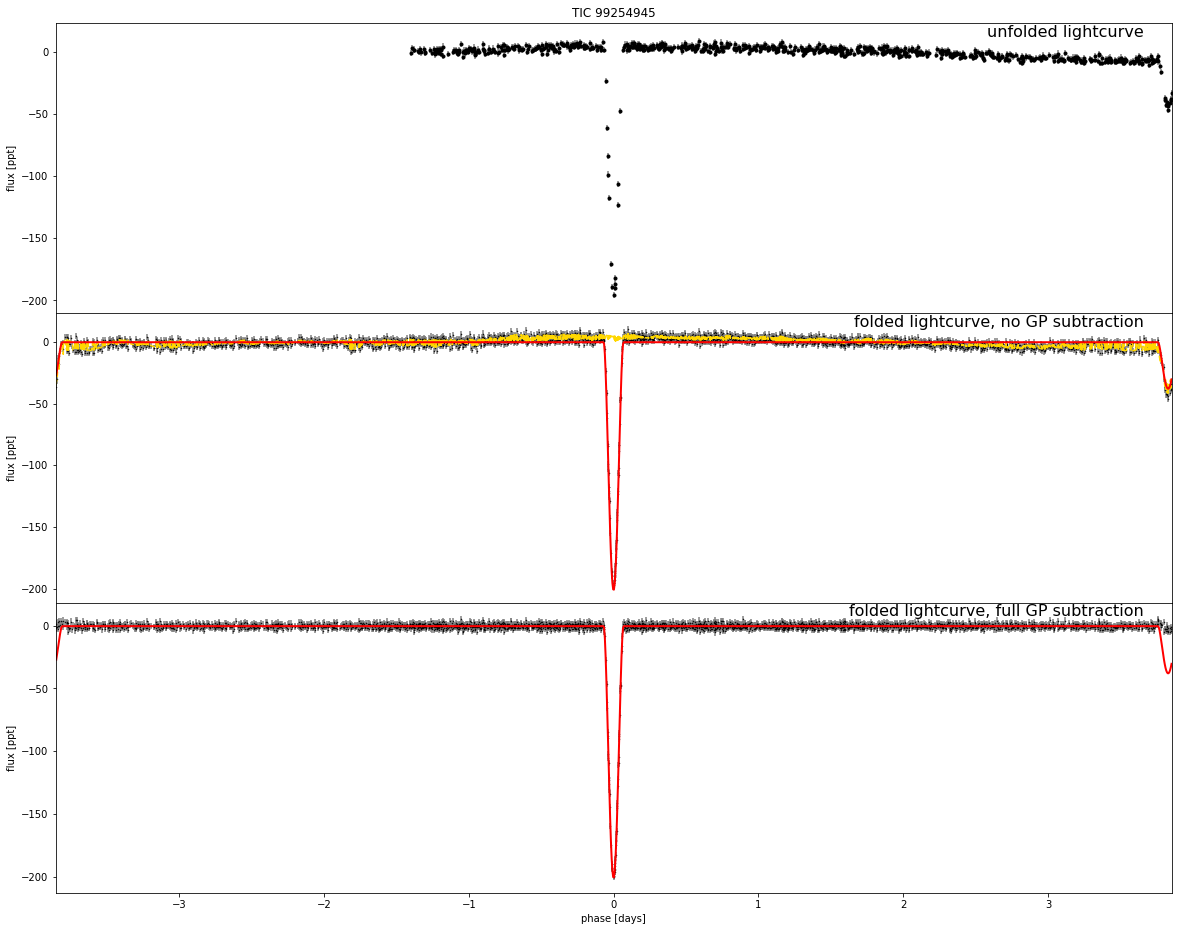

In [531]:
plot_3panel_LC_plot_gallery(TIC_TARGETs=['TIC 99254945'], Ntune=1000, Ndraw=500, chains=6, model_list=['8x'], save_to_disk=True)